# EDA and Forecasting of Water Reservoir Levels

## Introduction

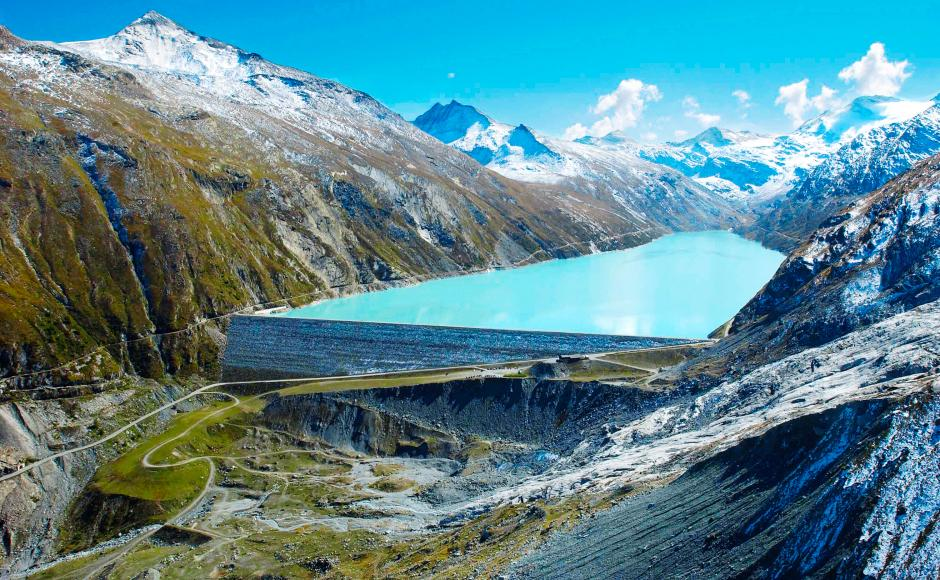

Picture: [The Water Resevoir Mattmark in Wallis](https://www.valais.ch/media/cache/single_image/e/3-erlebniss_staudamm-besichtigen_bearbeitet.jpg)

## Research Question

These are our questions:

- **Does melting snow caused by higher temperature have an influence on rising water reservoir levels?**

We assume that with raising temperature the snow to melt. This is especially true for summer periods, where we expect the water reservoir levels to raise. This would also indicate that the reservoir levels are time dependant. 

- **Which other variables such as solar radiation, rain amount or air-temperature might have influence on the water reservoir level and to which extend are they contributing to forecast water reservoir levels?**

We expect the different explanatory variables to interact with each other. Higher temperatures are causing snow to melt, which is most likely increasing the water reservoir levels. Years or seasons with high amount of rain, might further increase the melting of the snow or glaciers, causing water reservoir levels to increase even further.

# Methodology

We assume that the explanatory variables are correlated. Furthermore the Residuals are correlated. Therefore, it is not best practice to use a linear regression with usage of ordinary least-squared method (OLS). Due to this fact we are using a generalised least-squared (GLS) method, when computing the linear regression model.
<br>
<br>
**1.** In a first step we are defining a SARIMA-Model on the reservoir levels for the canton of "Wallis". The data is available from 2000 - 2020 in weekly intervalls. A SARIMA-Model is getting made, since the mean is constant. There is only a slighly increasing trend in the water reservoir levels, which was also causing an increase in the maximum amount of capacity of the water reservoirs. Furthermore, the variance is constant over time for the reservoir levels due to sinusoidal, seasonal behaviour.
<br>
<br>
**2.** On the basis of the SARIMA-Model we are forecasting the water reservoir levels. This will form the baseline. Additionally, we are comparing the SARIMA-Model with an AUTO-ARIMA-Model to see, which one of them is performing better in terms of how the fitted data looks like, (P)ACF of Residuals and the QQ-Plot of Residuals.
<br>
<br>
**3.** In a third step a linear regression model is computed with the OLS-method. Water reservoir level is the dependant variable and snowheight the independant variable. The data is splitted in training and test data, using 10-fold cross-validation.
<br>
<br>
**4.** The fourth steps is to compute a multiple linear regression model with the GLS-Method. Water reservoir level is the dependant variable and snowheight, solar radiation, temperature and rain amount form the independant variables. The two linear regression models are comparing looking at the R-squared, F-Test (Anova), RMSE and AIC. 
<br>
<br>
**5.** In a last step we are comparing the SARIMA or AUTO-ARIMA predictions with the predictions obtained from the linear regression model to analyse, which method is holding the better results in terms of accuracy (RMSE).




## Loading the Data

In [ ]:
# Look if pandas version is up to date. Otherwise the statsmodel package cannot communicate with pandas and will produce errors.
!pip show pandas

Name: pandas
Version: 1.3.5
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.8/dist-packages
Requires: pytz, python-dateutil, numpy
Required-by: xarray, vega-datasets, statsmodels, sklearn-pandas, seaborn, pymc, prophet, pmdarima, plotnine, pandas-profiling, pandas-gbq, pandas-datareader, mlxtend, mizani, holoviews, gspread-dataframe, google-colab, fix-yahoo-finance, fastai, db-dtypes, datascience, cufflinks, cmdstanpy, arviz, altair


In [ ]:
# In Google Collab we must install two packages to use it

#!pip uninstall pmdarima  # if necessary --> uninstall the outdated v ersion
!pip install pmdarima
#!pip uninstall statsmodels # if necessary --> uninstall the outdated v ersion
#!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive # Pathing in Google Collab
from pathlib import Path # Pathing in Google Collab
from pprint import pprint
import matplotlib.pyplot as plt  # Visualiations
import seaborn as sns # Visualiations
import scipy.stats #Pearson Correlation
import statistics
from math import sqrt
from sklearn.metrics import mean_squared_error

# Time Series Model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from time import time # to calculate how long a model takes to be fitted
from pmdarima import auto_arima

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading of Water Reservoir Dataset**

In [ ]:
# Define data folder:
data_folder = Path("/content/drive/MyDrive/Data Analytics for Energy Systems and IoT/data/")

# Path of product category data
data1 = data_folder/"ogd17_fuellungsgrad_speicherseen.csv"
data2 = data_folder/"Liste_Wettermessstationen.csv"

In [ ]:
df_water_reservoir = pd.read_csv(data1)
df_water_reservoir.head(5)

Datum  Wallis_speicherinhalt_gwh  Graubuenden_speicherinhalt_gwh  \
0  2000-01-03                       2037                            1226   
1  2000-01-10                       1945                            1175   
2  2000-01-17                       1733                            1063   
3  2000-01-24                       1584                             940   
4  2000-01-31                       1414                             803   

   Tessin_speicherinhalt_gwh  UebrigCH_speicherinhalt_gwh  \
0                        758                          904   
1                        720                          868   
2                        651                          777   
3                        591                          674   
4                        517                          581   

   TotalCH_speicherinhalt_gwh  Wallis_max_speicherinhalt_gwh  \
0                        4925                           3770   
1                        4708                           3770   
2                        4224                           3770   
3                        3789                           3770   
4                        3315                           3770   

   Graubuenden_max_speicherinhalt_gwh  Tessin_max_speicherinhalt_gwh  \
0                                1905                           1225   
1                                1905                           1225   
2                                1905                           1225   
3                                1905                           1225   
4                                1905                           1225   

   UebrigCH_max_speicherinhalt_gwh  TotalCH_max_speicherinhalt_gwh  
0                             1600                            8500  
1                             1600                            8500  
2                             1600                            8500  
3                             1600                            8500  
4                             1600                            8500

In [ ]:
df_water_reservoir.columns

Index(['Datum', 'Wallis_speicherinhalt_gwh', 'Graubuenden_speicherinhalt_gwh',
       'Tessin_speicherinhalt_gwh', 'UebrigCH_speicherinhalt_gwh',
       'TotalCH_speicherinhalt_gwh', 'Wallis_max_speicherinhalt_gwh',
       'Graubuenden_max_speicherinhalt_gwh', 'Tessin_max_speicherinhalt_gwh',
       'UebrigCH_max_speicherinhalt_gwh', 'TotalCH_max_speicherinhalt_gwh'],
      dtype='object')

In [ ]:
#Rename to english - so everybode can understand it
df_water_reservoir = df_water_reservoir.rename({"Datum": "Date",
                          "Wallis_speicherinhalt_gwh" : "Wallis_reservoir_content_gwh", 
                           "Graubuenden_speicherinhalt_gwh" : "Graubuenden_reservoir_content_gwh",
                           "Tessin_speicherinhalt_gwh" : "Tessin_reservoir_content_gwh",
                           "UebrigCH_speicherinhalt_gwh" : "RestCH_reservoir_content_gwh",
                            "TotalCH_speicherinhalt_gwh" : "TotalCH_reservoir_content_gwh", 
                             'Wallis_max_speicherinhalt_gwh' : "Wallis_reservoir_max_content_gwh",
                          'Graubuenden_max_speicherinhalt_gwh' : "Graubuenden_reservoir_max_content_gwh", 
                           'Tessin_max_speicherinhalt_gwh' : "Tessin_reservoir_max_content_gwh",
                            'UebrigCH_max_speicherinhalt_gwh' : "RestCH_reservoir_max_content_gwh", 
                           "TotalCH_max_speicherinhalt_gwh" :  "TotalCH_reservoir_max_content_gwh"
                           }, axis=1)
df_water_reservoir.head(5)

Date  Wallis_reservoir_content_gwh  \
0  2000-01-03                          2037   
1  2000-01-10                          1945   
2  2000-01-17                          1733   
3  2000-01-24                          1584   
4  2000-01-31                          1414   

   Graubuenden_reservoir_content_gwh  Tessin_reservoir_content_gwh  \
0                               1226                           758   
1                               1175                           720   
2                               1063                           651   
3                                940                           591   
4                                803                           517   

   RestCH_reservoir_content_gwh  TotalCH_reservoir_content_gwh  \
0                           904                           4925   
1                           868                           4708   
2                           777                           4224   
3                           674                           3789   
4                           581                           3315   

   Wallis_reservoir_max_content_gwh  Graubuenden_reservoir_max_content_gwh  \
0                              3770                                   1905   
1                              3770                                   1905   
2                              3770                                   1905   
3                              3770                                   1905   
4                              3770                                   1905   

   Tessin_reservoir_max_content_gwh  RestCH_reservoir_max_content_gwh  \
0                              1225                              1600   
1                              1225                              1600   
2                              1225                              1600   
3                              1225                              1600   
4                              1225                              1600   

   TotalCH_reservoir_max_content_gwh  
0                               8500  
1                               8500  
2                               8500  
3                               8500  
4                               8500

The Data starts from 01-03-2000 and have a continous data point in the column "Date" every week until the 21-11-2022. The 21-11-2022 is the date we extracted the data from opendata.swiss

All other columns are integer and represents the unit GWH. There are 4 different water reservoirs: Wallis, Graubuenden, Tessin and Rest. The total is the sum of all of these 4 reservoir regions.

In [ ]:
df_water_reservoir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Date                                   1195 non-null   object
 1   Wallis_reservoir_content_gwh           1195 non-null   int64 
 2   Graubuenden_reservoir_content_gwh      1195 non-null   int64 
 3   Tessin_reservoir_content_gwh           1195 non-null   int64 
 4   RestCH_reservoir_content_gwh           1195 non-null   int64 
 5   TotalCH_reservoir_content_gwh          1195 non-null   int64 
 6   Wallis_reservoir_max_content_gwh       1195 non-null   int64 
 7   Graubuenden_reservoir_max_content_gwh  1195 non-null   int64 
 8   Tessin_reservoir_max_content_gwh       1195 non-null   int64 
 9   RestCH_reservoir_max_content_gwh       1195 non-null   int64 
 10  TotalCH_reservoir_max_content_gwh      1195 non-null   int64 
dtypes: int64(10), obj

**Loading of Measuring Stations Information**

In [ ]:
df_measuring_stations = pd.read_csv(data2, sep=";", encoding ="latin-1")
df_measuring_stations.head(5)

Station station/location         WIGOS-ID  Data since  \
0            Altdorf              ALT  0-20000-0-06672  01.01.1864   
1          Andermatt              ANT  0-20000-0-06695  01.01.1864   
2  Basel / Binningen              BAS  0-20000-0-06601  01.01.1755   
3  Bern / Zollikofen              BER  0-20000-0-06631  01.01.1864   
4  La Chaux-de-Fonds              CDF  0-20000-0-06612  01.01.1900   

   Station height m. a. sea level  CoordinatesE  CoordinatesN   Latitude  \
0                           438.0     2690181.0     1193564.0  46.887069   
1                          1438.0     2687445.0     1165044.0  46.630914   
2                           316.0     2610909.0     1265612.0  47.541142   
3                           553.0     2601934.0     1204410.0  46.990744   
4                          1017.0     2550919.0     1214862.0  47.082947   

   Longitude              Climate region Canton  \
0   8.621894  Central Alpine north slope     UR   
1   8.580553  Central Alpine north slope     UR   
2   7.583525                Eastern Jura     BL   
3   7.464061             Central plateau     BE   
4   6.792314                Western Jura     NE   

                  URL Previous years (verified data)  \
0  https://data.geo.admin.ch/ch.meteoschweiz.klim...   
1  https://data.geo.admin.ch/ch.meteoschweiz.klim...   
2  https://data.geo.admin.ch/ch.meteoschweiz.klim...   
3  https://data.geo.admin.ch/ch.meteoschweiz.klim...   
4  https://data.geo.admin.ch/ch.meteoschweiz.klim...   

                                    URL Current year  
0  https://data.geo.admin.ch/ch.meteoschweiz.klim...  
1  https://data.geo.admin.ch/ch.meteoschweiz.klim...  
2  https://data.geo.admin.ch/ch.meteoschweiz.klim...  
3  https://data.geo.admin.ch/ch.meteoschweiz.klim...  
4  https://data.geo.admin.ch/ch.meteoschweiz.klim...

**Loading of Climate Dataset**

The weather data was obtained from opendata.swiss (https://opendata.swiss/de/dataset/klimamessnetz-tageswerte) and contains measurement from NBCN-Stations (Swiss National Basic Climate Network) from "MeteoSchweiz". The measurements are available on a daily basis. This means for certain variables there is daily data available dating back to the year 1864. 
<br>
<br>
The data is available from 29 different stations all over Switzerland. For the project we are focussing on the weather data from the station in the village "Grächen". This village is located in the canton of Wallis and is situated 1619 meters above sea level. 

In [ ]:
# Path of weather data for Grächen
data_weather = data_folder/"Wetterdaten_Graechen1900_2021.csv"

In [ ]:
# Load the weather-data
df_weather = pd.read_csv(data_weather, delimiter = ";")
df_weather.head(5)

station/location      date gre000d0 hto000d0 nto000d0 prestad0 rre150d0  \
0              GRC  18640101        -        -        -        -        0   
1              GRC  18640102        -        -        -        -      0.7   
2              GRC  18640103        -        -        -        -        0   
3              GRC  18640104        -        -        -        -        0   
4              GRC  18640105        -        -        -        -        0   

  sre000d0 tre200d0 tre200dn tre200dx ure200d0  
0        -     -5.5        -        -        -  
1        -    -11.6        -        -        -  
2        -    -16.6        -        -        -  
3        -     -6.2        -        -        -  
4        -     -6.9        -        -        -

In [ ]:
# Path of weather data for St.Bernard
data_weather = data_folder/"Wetterdaten_StBernhard_1900_2021.csv"

In [ ]:
# Load the weather-data
df_weather_stbernard = pd.read_csv(data_weather, delimiter = ";")
df_weather_stbernard.head(5)

station/location      date gre000d0 hto000d0 nto000d0 prestad0 rre150d0  \
0              GSB  18640101        -        -        -        -        -   
1              GSB  18640102        -        -        -        -        -   
2              GSB  18640103        -        -        -        -        -   
3              GSB  18640104        -        -        -        -        -   
4              GSB  18640105        -        -        -        -        -   

  sre000d0 tre200d0 tre200dn tre200dx ure200d0  
0        -    -10.5      -12     -8.2        -  
1        -    -15.7    -21.4    -10.7        -  
2        -    -20.3    -23.8    -16.5        -  
3        -    -12.5    -13.8    -10.5        -  
4        -    -12.8    -15.6    -11.1        -

**Loading of Electrictiy Statistics Dataset**

In [ ]:
# Path of weather data for Grächen
data_electric = data_folder/"5634-Zeitreihe_Elektrizitätsbilanz_Schweiz_Monatswerte.xlsx"

In [ ]:
# Load the weather-data
df_electric = pd.read_excel(data_electric, skiprows=15, header=None) 
df_electric.head(10)

0       1       2      3     4      5     6   \
0       Januar / Janvier 1990  2009.0  2185.0  134.0  4328   49.0  4279   
1      Februar / Février 1990  1805.0  1964.0  160.0  3929   67.0  3862   
2            März / Mars 1990  2437.0  2172.0  127.0  4736   40.0  4696   
3          April / Avril 1990  2220.0  2105.0   72.0  4397   62.0  4335   
4              Mai / Mai 1990  2897.0  1940.0   60.0  4897  249.0  4648   
5            Juni / Juin 1990  3381.0  1188.0   54.0  4623  212.0  4411   
6         Juli / Juillet 1990  3570.0  1592.0   61.0  5223  321.0  4902   
7          August / Août 1990  3103.0   910.0   55.0  4068  305.0  3763   
8  September / Septembre 1990  2337.0  1831.0   61.0  4229  172.0  4057   
9      Oktober / Octobre 1990  2288.0  2131.0   81.0  4500   92.0  4408   

       7       8     9      10    11    12   13  
0  2616.0  1974.0  4921  332.0  4589   642  NaN  
1  2113.0  1741.0  4234  313.0  3921   372  NaN  
2  1895.0  2100.0  4491  334.0  4157  -205  NaN  
3  1799.0  2015.0  4119  323.0  3796  -216  NaN  
4  1423.0  2202.0  3869  288.0  3581  -779  NaN  
5  1521.0  2158.0  3774  261.0  3513  -637  NaN  
6  1287.0  2557.0  3632  286.0  3346 -1270  NaN  
7  1735.0  1850.0  3648  275.0  3373  -115  NaN  
8  1921.0  2173.0  3805  279.0  3526  -252  NaN  
9  2107.0  2228.0  4287  320.0  3967  -121  NaN

In [ ]:
# Rename Header because it is was badly formatted in Excel
df_electric.drop(columns = [13], inplace = True)

df_electric = df_electric.rename({0: "Month / Year",
                          1 : "Hydropower plants",  # Electriticy generation
                           2 : "Nuclear power plants", #Electriticy generation
                           3 : "Conv. therm. and renewable power plants", # Electriticy generation
                           4 : "Total", # Total Electriticy generation
                            5 : "Storage pump consumption", 
                             6 : "Net production", 
                          7 : "Import", 
                           8 : "Export",
                            9 : "National consumption", 
                           10 :  "Losses",
                           11 :  "Final consumption", #with losses
                           12 :  "Export-Import-Saldo"}, axis=1)
df_electric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Month / Year                             393 non-null    object 
 1   Hydropower plants                        393 non-null    float64
 2   Nuclear power plants                     393 non-null    float64
 3   Conv. therm. and renewable power plants  393 non-null    float64
 4   Total                                    393 non-null    int64  
 5   Storage pump consumption                 393 non-null    float64
 6   Net production                           393 non-null    int64  
 7   Import                                   393 non-null    float64
 8   Export                                   393 non-null    float64
 9   National consumption                     393 non-null    int64  
 10  Losses                                   393 non-n

In [ ]:
df_electric.head(5)

Month / Year  Hydropower plants  Nuclear power plants  \
0   Januar / Janvier 1990             2009.0                2185.0   
1  Februar / Février 1990             1805.0                1964.0   
2        März / Mars 1990             2437.0                2172.0   
3      April / Avril 1990             2220.0                2105.0   
4          Mai / Mai 1990             2897.0                1940.0   

   Conv. therm. and renewable power plants  Total  Storage pump consumption  \
0                                    134.0   4328                      49.0   
1                                    160.0   3929                      67.0   
2                                    127.0   4736                      40.0   
3                                     72.0   4397                      62.0   
4                                     60.0   4897                     249.0   

   Net production  Import  Export  National consumption  Losses  \
0            4279  2616.0  1974.0                  4921   332.0   
1            3862  2113.0  1741.0                  4234   313.0   
2            4696  1895.0  2100.0                  4491   334.0   
3            4335  1799.0  2015.0                  4119   323.0   
4            4648  1423.0  2202.0                  3869   288.0   

   Final consumption  Export-Import-Saldo  
0               4589                  642  
1               3921                  372  
2               4157                 -205  
3               3796                 -216  
4               3581                 -779

## Data Cleaning and Transformation

**Cleaning of Water Reservoir Dataset**

*Check for duplicates*

In [ ]:
def duplicate_check(df):
  print(df.duplicated().sum())
  duplicates = df[df.duplicated(keep=False)]
  print(duplicates)
  return duplicates

In [ ]:
# Call created function
duplicate_check(df_water_reservoir)


0
Empty DataFrame
Columns: [Date, Wallis_reservoir_content_gwh, Graubuenden_reservoir_content_gwh, Tessin_reservoir_content_gwh, RestCH_reservoir_content_gwh, TotalCH_reservoir_content_gwh, Wallis_reservoir_max_content_gwh, Graubuenden_reservoir_max_content_gwh, Tessin_reservoir_max_content_gwh, RestCH_reservoir_max_content_gwh, TotalCH_reservoir_max_content_gwh]
Index: []


Empty DataFrame
Columns: [Date, Wallis_reservoir_content_gwh, Graubuenden_reservoir_content_gwh, Tessin_reservoir_content_gwh, RestCH_reservoir_content_gwh, TotalCH_reservoir_content_gwh, Wallis_reservoir_max_content_gwh, Graubuenden_reservoir_max_content_gwh, Tessin_reservoir_max_content_gwh, RestCH_reservoir_max_content_gwh, TotalCH_reservoir_max_content_gwh]
Index: []

*Check for missing values*

In [ ]:
def missing_values_check(df):
  print(df.isna().sum())
  missing_values = df.columns[df.isna().any(0)].tolist()
  print(missing_values)

  if missing_values:
    print("Found the following missing values:" , df.isna())
  else: print("Found no missing values")

In [ ]:
# Call created function
missing_values_check(df_water_reservoir)


Date                                     0
Wallis_reservoir_content_gwh             0
Graubuenden_reservoir_content_gwh        0
Tessin_reservoir_content_gwh             0
RestCH_reservoir_content_gwh             0
TotalCH_reservoir_content_gwh            0
Wallis_reservoir_max_content_gwh         0
Graubuenden_reservoir_max_content_gwh    0
Tessin_reservoir_max_content_gwh         0
RestCH_reservoir_max_content_gwh         0
TotalCH_reservoir_max_content_gwh        0
dtype: int64
[]
Found no missing values


*Data Transformation: Change Datatype*

In [ ]:
 # Step 1: Convert Date in to date_time datatype
df_water_reservoir['Date']=pd.to_datetime(df_water_reservoir['Date'], format='%Y-%m-%d')

# Step2: Calculate The Year and Month
df_water_reservoir['Year']=pd.DatetimeIndex(df_water_reservoir['Date']).year
df_water_reservoir['Month']=pd.DatetimeIndex(df_water_reservoir['Date']).month

**Cleaning of Weather-Data**

The column-, respectively variable names are not yet renamed to guarantee better interpretability. The exact variable name and the measuring units are listed in the READ-ME File from opendata.swiss:

**Parameter: Description**

- *gre000d0*: Globalstrahlung; Tagesmittel
- *hto000d0*: Gesamtschneehöhe; Morgenmessung von 6 UTC
- *nto000d0*: Gesamtbewölkung; Tagesmittel
- *prestad0*: Luftdruck auf Stationshöhe (QFE) Tagesmittel
- *rre150d0*: Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag
- *sre000d0*: Sonnenscheindauer; Tagessumme
- *tre200d0*: Lufttemperatur 2 m über Boden; Tagesmittel
- *tre200dn*: Lufttemperatur 2 m über Boden; Tagesminimum
- *tre200dx*: Lufttemperatur 2 m über Boden; Tagesmaximum
- *ure200d0*: Relative Luftfeuchtigkeit 2 m über Boden; Tagesmittel

In [ ]:
# Rename the column-names
df_weather.rename({"station/location": "station/location",
           "date": "date",
           "gre000d0": "solar_radiation_daily_avg",
           "hto000d0": "snowheight_measure_6am",
           "nto000d0": "cloudiness_daily_avg",
           "prestad0": "air_pressure_daily_avg",
           "rre150d0": "rain_sum",
           "sre000d0": "solar_radiation_duration_daily_sum",
           "tre200d0": "air_temperature_2m_above_surface_daily_avg",
           "tre200dn": "air_temperature_2m_above_surface_daily_min",
           "tre200dx": "air_temperature_2m_above_surface_daily_max",
           "ure200d0": "relative_humidity_2m_above_surface_daily_avg"
          }, axis=1, inplace=True)

In [ ]:
# Rename the column-names
df_weather_stbernard.rename({"station/location": "station/location",
                            "date": "date",
                            "gre000d0": "solar_radiation_daily_avg",
                            "hto000d0": "snowheight_measure_6am",
                            "nto000d0": "cloudiness_daily_avg",
                            "prestad0": "air_pressure_daily_avg",
                            "rre150d0": "rain_sum",
                            "sre000d0": "solar_radiation_duration_daily_sum",
                            "tre200d0": "air_temperature_2m_above_surface_daily_avg",
                            "tre200dn": "air_temperature_2m_above_surface_daily_min",
                            "tre200dx": "air_temperature_2m_above_surface_daily_max",
                            "ure200d0": "relative_humidity_2m_above_surface_daily_avg"
                            }, axis=1, inplace=True)

Now the weather-data is check for missing values: There seems to be no missing values, at least not obvious or encoded ones.

In [ ]:
df_weather.isna().sum()

station/location                                0
date                                            0
solar_radiation_daily_avg                       0
snowheight_measure_6am                          0
cloudiness_daily_avg                            0
air_pressure_daily_avg                          0
rain_sum                                        0
solar_radiation_duration_daily_sum              0
air_temperature_2m_above_surface_daily_avg      0
air_temperature_2m_above_surface_daily_min      0
air_temperature_2m_above_surface_daily_max      0
relative_humidity_2m_above_surface_daily_avg    0
dtype: int64

In [ ]:
df_weather_stbernard.isna().sum()

station/location                                0
date                                            0
solar_radiation_daily_avg                       0
snowheight_measure_6am                          0
cloudiness_daily_avg                            0
air_pressure_daily_avg                          0
rain_sum                                        0
solar_radiation_duration_daily_sum              0
air_temperature_2m_above_surface_daily_avg      0
air_temperature_2m_above_surface_daily_min      0
air_temperature_2m_above_surface_daily_max      0
relative_humidity_2m_above_surface_daily_avg    0
dtype: int64

In [ ]:
# The missing values have to be removed

missing = []
value = []

for i in df_weather["solar_radiation_daily_avg"]:
    if i == "-":
        missing.append(i)
    else:
        value.append(i)

print("Total amout of observations:", len(missing) + len(value))
print("Total amout of missing observations:", len(missing))
print("Total amout of values in  observations:", len(value))

Total amout of observations: 57709
Total amout of missing observations: 54572
Total amout of values in  observations: 3137


There are some missing values --> If there is a missing measurement because either the measurement was not yet taken or there was an error (or many other reasons, which might occur) there is a "-" in the data. This measurement is getting replaced with 0, to ensure that at least all the data in the measurement columns is of type integer.

In [ ]:
# Replace the "-" with 0
df_weather = df_weather.replace("-", 0)
df_weather_stbernard = df_weather_stbernard.replace("-", 0)

In [ ]:
# Check the datatypes:
print(df_weather.dtypes)
print(80*"*")
print(df_weather_stbernard.dtypes)

station/location                                object
date                                             int64
solar_radiation_daily_avg                       object
snowheight_measure_6am                          object
cloudiness_daily_avg                            object
air_pressure_daily_avg                          object
rain_sum                                        object
solar_radiation_duration_daily_sum              object
air_temperature_2m_above_surface_daily_avg      object
air_temperature_2m_above_surface_daily_min      object
air_temperature_2m_above_surface_daily_max      object
relative_humidity_2m_above_surface_daily_avg    object
dtype: object
********************************************************************************
station/location                                object
date                                             int64
solar_radiation_daily_avg                       object
snowheight_measure_6am                           int64
cloudiness_daily_avg     

In [ ]:
# Refactor the datatypes of the columns --> float or date
# Using dictionary to convert specific columns
convert_dict = {"station/location": object,
                "date": str,
                "solar_radiation_daily_avg": float, 
                "snowheight_measure_6am": float,
                "cloudiness_daily_avg": float,
                "air_pressure_daily_avg": float,
                "rain_sum": float,
                "solar_radiation_duration_daily_sum": float,
                "air_temperature_2m_above_surface_daily_avg": float,
                "air_temperature_2m_above_surface_daily_min": float,
                "air_temperature_2m_above_surface_daily_max": float,
                "relative_humidity_2m_above_surface_daily_avg": float
                }
 
    
df_weather = df_weather.astype(convert_dict)
# Convert date-column
df_weather['date']= pd.to_datetime(df_weather['date'])
print(df_weather.dtypes)

station/location                                        object
date                                            datetime64[ns]
solar_radiation_daily_avg                              float64
snowheight_measure_6am                                 float64
cloudiness_daily_avg                                   float64
air_pressure_daily_avg                                 float64
rain_sum                                               float64
solar_radiation_duration_daily_sum                     float64
air_temperature_2m_above_surface_daily_avg             float64
air_temperature_2m_above_surface_daily_min             float64
air_temperature_2m_above_surface_daily_max             float64
relative_humidity_2m_above_surface_daily_avg           float64
dtype: object


In [ ]:
# Refactor the datatypes of the columns --> float or date
# Using dictionary to convert specific columns
convert_dict = {"station/location": object,
                "date": str,
                "solar_radiation_daily_avg": float, 
                "snowheight_measure_6am": float,
                "cloudiness_daily_avg": float,
                "air_pressure_daily_avg": float,
                "rain_sum": float,
                "solar_radiation_duration_daily_sum": float,
                "air_temperature_2m_above_surface_daily_avg": float,
                "air_temperature_2m_above_surface_daily_min": float,
                "air_temperature_2m_above_surface_daily_max": float,
                "relative_humidity_2m_above_surface_daily_avg": float
                }
 
    
df_weather_stbernard = df_weather_stbernard.astype(convert_dict)
# Convert date-column
df_weather_stbernard['date']= pd.to_datetime(df_weather_stbernard['date'])
print(df_weather_stbernard.dtypes)

station/location                                        object
date                                            datetime64[ns]
solar_radiation_daily_avg                              float64
snowheight_measure_6am                                 float64
cloudiness_daily_avg                                   float64
air_pressure_daily_avg                                 float64
rain_sum                                               float64
solar_radiation_duration_daily_sum                     float64
air_temperature_2m_above_surface_daily_avg             float64
air_temperature_2m_above_surface_daily_min             float64
air_temperature_2m_above_surface_daily_max             float64
relative_humidity_2m_above_surface_daily_avg           float64
dtype: object


Now the data and the datatype seem to be accurate. The dataset, the distribution of the different variables and the development over time of the measurment-variables is getting examined. In a first step the inital dataframe, containing observations from the 01. January 1864 up until 31. December 2021 is getting truncated. Only observations within the time-period from 2000 until 2021 are of interest, since the data for the water reservoirs falls as well in this time period.

In [ ]:
# The dataframe is getting cut to only get the values from 2000 and younger
df_weather_2000 = df_weather[df_weather["date"] > "2000-01-01"]
df_weather_2000.head(5)

station/location       date  solar_radiation_daily_avg  \
49674              GRC 2000-01-02                        0.0   
49675              GRC 2000-01-03                        0.0   
49676              GRC 2000-01-04                        0.0   
49677              GRC 2000-01-05                        0.0   
49678              GRC 2000-01-06                        0.0   

       snowheight_measure_6am  cloudiness_daily_avg  air_pressure_daily_avg  \
49674                    53.0                  46.0                     0.0   
49675                    53.0                   8.0                     0.0   
49676                    52.0                   0.0                     0.0   
49677                    50.0                  17.0                     0.0   
49678                    49.0                  25.0                     0.0   

       rain_sum  solar_radiation_duration_daily_sum  \
49674       0.0                                 0.0   
49675       0.0                                 0.0   
49676       0.0                                 0.0   
49677       0.0                                 0.0   
49678       0.0                                 0.0   

       air_temperature_2m_above_surface_daily_avg  \
49674                                        -1.5   
49675                                         0.5   
49676                                         0.9   
49677                                         0.5   
49678                                         1.3   

       air_temperature_2m_above_surface_daily_min  \
49674                                        -5.5   
49675                                        -4.0   
49676                                        -1.5   
49677                                        -2.5   
49678                                        -1.5   

       air_temperature_2m_above_surface_daily_max  \
49674                                         0.5   
49675                                         6.0   
49676                                         6.5   
49677                                         5.0   
49678                                         6.0   

       relative_humidity_2m_above_surface_daily_avg  
49674                                          48.6  
49675                                          39.2  
49676                                          36.1  
49677                                          59.6  
49678                                          40.2

In [ ]:
# The dataframe is getting cut to only get the values from 2000 and younger
df_weather_stbernard_2000 = df_weather_stbernard[df_weather_stbernard["date"] > "2000-01-01"]
df_weather_stbernard_2000.head(5)

station/location       date  solar_radiation_daily_avg  \
49674              GSB 2000-01-02                       41.0   
49675              GSB 2000-01-03                       37.0   
49676              GSB 2000-01-04                       41.0   
49677              GSB 2000-01-05                       39.0   
49678              GSB 2000-01-06                       53.0   

       snowheight_measure_6am  cloudiness_daily_avg  air_pressure_daily_avg  \
49674                     0.0                  46.0                   758.1   
49675                     0.0                   0.0                   760.2   
49676                     0.0                  17.0                   756.9   
49677                     0.0                  42.0                   755.9   
49678                     0.0                  54.0                   755.5   

       rain_sum  solar_radiation_duration_daily_sum  \
49674       0.0                                62.0   
49675       0.0                               106.0   
49676       0.0                               108.0   
49677       0.0                                65.0   
49678       0.0                                 1.0   

       air_temperature_2m_above_surface_daily_avg  \
49674                                        -4.1   
49675                                        -2.5   
49676                                        -2.9   
49677                                        -3.5   
49678                                        -3.4   

       air_temperature_2m_above_surface_daily_min  \
49674                                        -7.8   
49675                                        -3.8   
49676                                        -7.4   
49677                                        -6.0   
49678                                        -5.1   

       air_temperature_2m_above_surface_daily_max  \
49674                                        -0.8   
49675                                        -0.9   
49676                                        -0.4   
49677                                         0.1   
49678                                        -0.6   

       relative_humidity_2m_above_surface_daily_avg  
49674                                          47.4  
49675                                          31.1  
49676                                          35.5  
49677                                          60.9  
49678                                          37.1

**Cleaning of Electriticy Statistics Dataset**

*Check for duplicates*

In [ ]:
# Call created function
duplicate_check(df_electric)

0
Empty DataFrame
Columns: [Month / Year, Hydropower plants, Nuclear power plants, Conv. therm. and renewable power plants, Total, Storage pump consumption, Net production, Import, Export, National consumption, Losses, Final consumption, Export-Import-Saldo]
Index: []


Empty DataFrame
Columns: [Month / Year, Hydropower plants, Nuclear power plants, Conv. therm. and renewable power plants, Total, Storage pump consumption, Net production, Import, Export, National consumption, Losses, Final consumption, Export-Import-Saldo]
Index: []

*Check for missing values*

In [ ]:
missing_values_check(df_electric)

Month / Year                               0
Hydropower plants                          0
Nuclear power plants                       0
Conv. therm. and renewable power plants    0
Total                                      0
Storage pump consumption                   0
Net production                             0
Import                                     0
Export                                     0
National consumption                       0
Losses                                     0
Final consumption                          0
Export-Import-Saldo                        0
dtype: int64
[]
Found no missing values


*Data Transformation: Change Datatype*

In [ ]:
year_list = []
month_list = []

for row in df_electric["Month / Year"]:
  #print(row)
  #print(type(row))
  year = row[-4:] #slice
  year_list.append(year)
  #print(year)
  month_tuple = row[0:-4].partition("/")
  month = month_tuple[0].lstrip()
  month_list.append(month)
  #print(month)

df_electric["Year"] = year_list
df_electric["Month"] = month_list

In [ ]:
df_electric.head(5)

Month / Year  Hydropower plants  Nuclear power plants  \
0   Januar / Janvier 1990             2009.0                2185.0   
1  Februar / Février 1990             1805.0                1964.0   
2        März / Mars 1990             2437.0                2172.0   
3      April / Avril 1990             2220.0                2105.0   
4          Mai / Mai 1990             2897.0                1940.0   

   Conv. therm. and renewable power plants  Total  Storage pump consumption  \
0                                    134.0   4328                      49.0   
1                                    160.0   3929                      67.0   
2                                    127.0   4736                      40.0   
3                                     72.0   4397                      62.0   
4                                     60.0   4897                     249.0   

   Net production  Import  Export  National consumption  Losses  \
0            4279  2616.0  1974.0                  4921   332.0   
1            3862  2113.0  1741.0                  4234   313.0   
2            4696  1895.0  2100.0                  4491   334.0   
3            4335  1799.0  2015.0                  4119   323.0   
4            4648  1423.0  2202.0                  3869   288.0   

   Final consumption  Export-Import-Saldo  Year     Month  
0               4589                  642  1990   Januar   
1               3921                  372  1990  Februar   
2               4157                 -205  1990     März   
3               3796                 -216  1990    April   
4               3581                 -779  1990      Mai

## EDA

### Electricity Statistics Dataset

In [ ]:
df_electric.columns

Index(['Month / Year', 'Hydropower plants', 'Nuclear power plants',
       'Conv. therm. and renewable power plants', 'Total',
       'Storage pump consumption', 'Net production', 'Import', 'Export',
       'National consumption', 'Losses', 'Final consumption',
       'Export-Import-Saldo', 'Year', 'Month'],
      dtype='object')

**Histograms**

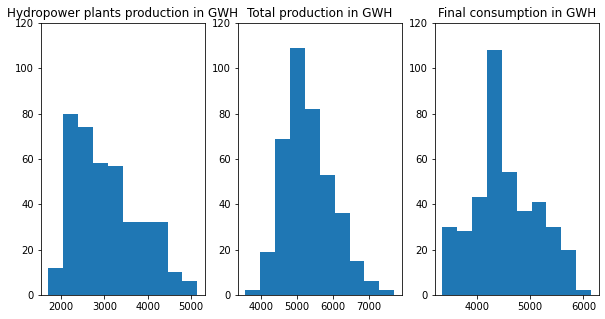

In [ ]:
# Histogram for  Hydropower plants, Total and Final consumption

hydropower = df_electric["Hydropower plants"]
total = df_electric["Total"]

net_prod = df_electric["Net production"]
final_consum = df_electric["Final consumption"]


# Creating histogram
fig, (ax1, ax2, ax4) = plt.subplots(nrows = 1, ncols = 3, figsize=(10,5))

ax1.hist(hydropower)
ax1.set_title("Hydropower plants production in GWH")
#ax1.set_xlim([0,4000])
ax1.set_ylim([0,120])

ax2.hist(total)
ax2.set_title("Total production in GWH")
#ax2.set_xlim([0,5000])
ax2.set_ylim([0,120])

ax4.hist(final_consum)
ax4.set_title("Final consumption in GWH")
#ax4.set_xlim([0,5000])
ax4.set_ylim([0,120])

# Show plot
plt.show()

**Intpretation**: The histogram for Hydropower plants production is right skrewed. It means that many data is accumulated in a relatively small range at around 2200-3500 GWH. 

The total production and final consumption histograms are more centered. But they show very high peaks in the center.


**Line Charts**

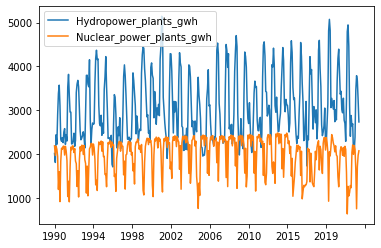

In [ ]:
# Line Charts: Nuclear and Hyropower over time
Hydropower = df_electric["Hydropower plants"].values.tolist()
Nuclear = df_electric["Nuclear power plants"].values.tolist()
data = {"Hydropower_plants_gwh":Hydropower, "Nuclear_power_plants_gwh":Nuclear}

index = df_electric["Year"].values.tolist()

df_lines= pd.DataFrame(data=data, index=index);
lines = df_lines.plot.line()

**Intpretation**: The temporal course of electricity production over all years does have strong changes in variance at some points. There is a slight positive trend for hydropower. However, the observation of the peaks allows the following analysis: When there is a peak (high) in hydropower production, there is simultaneously a low in nuclear energy production.

Besides one can see that only at very few times did nuclear power production exceed hydroelectric production.

A zoom into one random year can justify the observation:

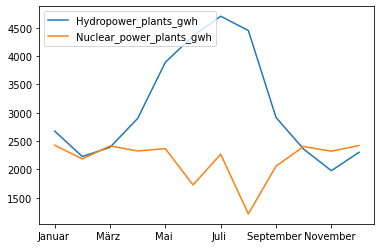

In [ ]:
# Line Charts: Nuclear and Hyropower over time - Zoom into one year

df_electric_one_year = df_electric.query("Year == '2009'")

Hydropower = df_electric_one_year["Hydropower plants"].values.tolist()
Nuclear = df_electric_one_year["Nuclear power plants"].values.tolist()
data = {"Hydropower_plants_gwh":Hydropower, "Nuclear_power_plants_gwh":Nuclear}

index = df_electric_one_year["Month"].values.tolist()

df_lines= pd.DataFrame(data=data, index=index);
lines = df_lines.plot.line()

**Interpretation**: The hydropower production increases after the month march and starts decreasing in September.

Furthermore we can see that the nuclear energy production has the lowest point when the hyropower production has the highest. This is around August/September.

Lastly atom energy increases after October and is relative constant until May, where its start to decrease.

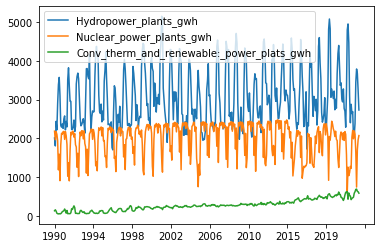

In [ ]:
# Line Charts: The three different energy categories over Time
Hydropower = df_electric["Hydropower plants"].values.tolist()
Nuclear = df_electric["Nuclear power plants"].values.tolist()
Conv_therm_renewable_power_gwh = df_electric["Conv. therm. and renewable power plants"].values.tolist()
data = {"Hydropower_plants_gwh":Hydropower, "Nuclear_power_plants_gwh":Nuclear, "Conv_therm_and_renewable:_power_plats_gwh": Conv_therm_renewable_power_gwh}

index = df_electric["Year"].values.tolist()

df_lines= pd.DataFrame(data=data, index=index);
lines = df_lines.plot.line()

**Interpretation**: Adding the last energy category from data set it can be observed that conv. therm. and renewable power plants production has a slightly increased since 1990 (slight positive trend). As the statistics do not distinguish between renewable (sun, wind, biomass, etc.) and conventional thermic production (gas, oil, etc.), we cannot evaluate further which of the one has an increase. However according to a quick google it is said that:
...

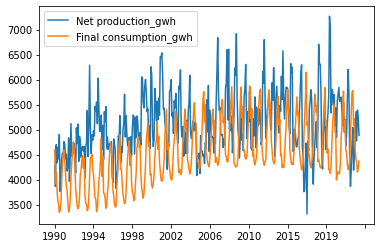

In [ ]:
# Line Charts: Net production vs Final consumption

Net_Production = df_electric["Net production"].values.tolist()
Final_Consumption = df_electric["Final consumption"].values.tolist()
data = {"Net production_gwh":Net_Production, "Final consumption_gwh":Final_Consumption}

index = df_electric["Year"].values.tolist()

df_lines= pd.DataFrame(data=data, index=index);
lines = df_lines.plot.line()

**Intpretation**: There is a positive trend in the final consumption and the net production. One could also say that there is a slow decrease of the final consumption since 2020.

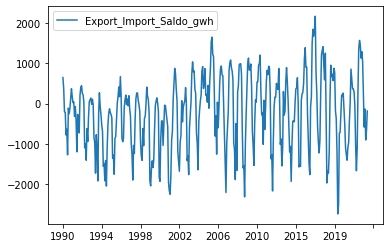

In [ ]:
# Line Charts: Export and Import Saldo
Export_Import_Saldo = df_electric["Export-Import-Saldo"].values.tolist()
data = {"Export_Import_Saldo_gwh":Export_Import_Saldo}

index = df_electric["Year"].values.tolist()

df_lines= pd.DataFrame(data=data, index=index);
lines = df_lines.plot.line()

**Interpretation**: The time series shows variations in export-import that repeatedly exceed or fall below the 0 value with varying intensity. No trend is visually observable. The reason for the variance in the data is seasonal, as a large part of the production is based on hydropower and therefore more must be imported in the winter months if there is a shortage.

In [ ]:
max_val = max(Export_Import_Saldo)
df_electric_max = df_electric[df_electric['Export-Import-Saldo'] == max_val]

df_electric_max

Month / Year  Hydropower plants  Nuclear power plants  \
325  Februar / Février 2017             1725.0                1369.0   

     Conv. therm. and renewable power plants  Total  Storage pump consumption  \
325                                    465.0   3559                     246.0   

     Net production  Import  Export  National consumption  Losses  \
325            3313  4100.0  1939.0                  5474   386.0   

     Final consumption  Export-Import-Saldo  Year     Month  
325               5088                 2161  2017  Februar

In [ ]:
min_val = min(Export_Import_Saldo)
df_electric_min = df_electric[df_electric['Export-Import-Saldo'] == min_val]
df_electric_min

Month / Year  Hydropower plants  Nuclear power plants  \
354  Juli / Juillet 2019             5074.0                2047.0   

     Conv. therm. and renewable power plants  Total  Storage pump consumption  \
354                                    574.0   7695                     428.0   

     Net production  Import  Export  National consumption  Losses  \
354            7267  1210.0  3943.0                  4534   339.0   

     Final consumption  Export-Import-Saldo  Year  Month  
354               4195                -2733  2019  Juli

**Interpretation**: 
- Positive Export Import Saldo: More Import than Exports from abroad
The highest positive Export-Import Saldo was in February 2017 with a value of 2161 GWH. Switzerland imported 4100 and exported only 1939 GWH. We can see that the National Consumption with 5474 GWH for that month was higher than the Total Production of 3559 GWH. 

- Negative Export-Import-Saldo: More Exports than Imports from abroad   The highest positive Export-Import Saldo was in February 2017 with a value of 2161 GWH. Switzerland imported 4100 and exported only 1939 GWH.


Why does Switzerland import and export at the same time? 

Answer: As learned in a lecture (I think it was from Philip). Switzerland is a transit country for electrical poower. One graphic I found can explain it pretty well : [Source: Elektrizitätsstatistik PDF from 2021](https://www.bfe.admin.ch/bfe/de/home/versorgung/statistik-und-geodaten/energiestatistiken/elektrizitaetsstatistik.exturl.html/aHR0cHM6Ly9wdWJkYi5iZmUuYWRtaW4uY2gvZGUvcHVibGljYX/Rpb24vZG93bmxvYWQvMTA5NDI=.html)

In the graphic below you can see that many imported electrical power in 2021 is exported to Italy. 

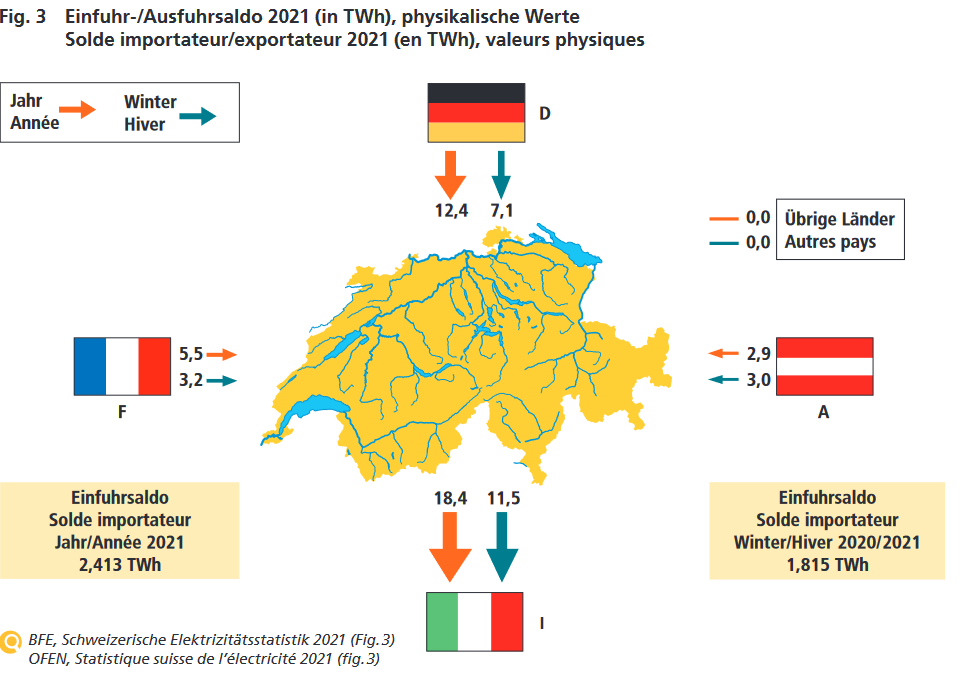

**Pie Chart**

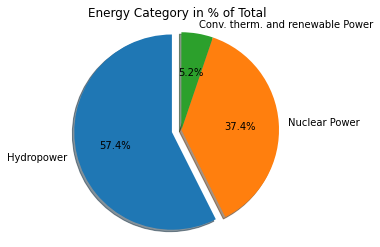

In [ ]:
# Pie Chart with the sums of the water reservoir
Hydropower_gwh_sum = df_electric["Hydropower plants"].sum()
Nuclear_power_gwh_sum = df_electric["Nuclear power plants"].sum()
Conv_therm_renewable_power_gwh_sum = df_electric["Conv. therm. and renewable power plants"].sum() #Fossil (Gas, Oil) and Sun, Wind, Biomass 
Total_gwh_sum = df_electric["Total"].sum()

# In % of Total
x1 = Hydropower_gwh_sum/Total_gwh_sum
x2 = Nuclear_power_gwh_sum/Total_gwh_sum
x3 = Conv_therm_renewable_power_gwh_sum/Total_gwh_sum

sizes = [x1,x2,x3]

labels = 'Hydropower', 'Nuclear Power', 'Conv. therm. and renewable Power'
explode = (0.1, 0, 0)  # it will take out (highlight) one part of the plot --> Hydropower in this case

fig1, ax1 = plt.subplots()
plt.title("Energy Category in % of Total")
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90) #shadow true makes it looks nicer, autopct is for formatting the legend, startangle says on which position hydropower will start
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

**Interpretation**: By considering the total sum per energy category divided by the total sum of all energy categories one can see that the hydropower has the highest share with 57,4 %, followed by the nuclear power. 

**Pearsons Correlation**

In [ ]:
# Correlation matrix of all:
cor_matrix = df_electric.corr()
round(cor_matrix,2)

Hydropower plants  \
Hydropower plants                                     1.00   
Nuclear power plants                                 -0.51   
Conv. therm. and renewable power plants               0.07   
Total                                                 0.81   
Storage pump consumption                              0.58   
Net production                                        0.76   
Import                                               -0.69   
Export                                                0.41   
National consumption                                 -0.42   
Losses                                               -0.45   
Final consumption                                    -0.42   
Export-Import-Saldo                                  -0.82   

                                         Nuclear power plants  \
Hydropower plants                                       -0.51   
Nuclear power plants                                     1.00   
Conv. therm. and renewable power plants                 -0.00   
Total                                                    0.06   
Storage pump consumption                                -0.47   
Net production                                           0.16   
Import                                                   0.36   
Export                                                   0.14   
National consumption                                     0.49   
Losses                                                   0.49   
Final consumption                                        0.49   
Export-Import-Saldo                                      0.24   

                                         Conv. therm. and renewable power plants  \
Hydropower plants                                                           0.07   
Nuclear power plants                                                       -0.00   
Conv. therm. and renewable power plants                                     1.00   
Total                                                                       0.29   
Storage pump consumption                                                    0.54   
Net production                                                              0.20   
Import                                                                      0.23   
Export                                                                     -0.05   
National consumption                                                        0.51   
Losses                                                                      0.54   
Final consumption                                                           0.51   
Export-Import-Saldo                                                         0.22   

                                         Total  Storage pump consumption  \
Hydropower plants                         0.81                      0.58   
Nuclear power plants                      0.06                     -0.47   
Conv. therm. and renewable power plants   0.29                      0.54   
Total                                     1.00                      0.46   
Storage pump consumption                  0.46                      1.00   
Net production                            0.98                      0.30   
Import                                   -0.50                     -0.39   
Export                                    0.54                      0.01   
National consumption                     -0.06                     -0.19   
Losses                                   -0.08                     -0.16   
Final consumption                        -0.06                     -0.19   
Export-Import-Saldo                      -0.72                     -0.35   

                                         Net production  Import  Export  \
Hydropower plants                                  0.76   -0.69    0.41   
Nuclear power plants                               0.16    0.36    0.14   
Conv. therm. and renewable power plants            0.20    0.23   -0.05   
Total 

**Interpretation**: By looking at the correlation coefficients one could say that the hyrdopower plants have a strong positive (linear) correlation on total production with a score of 0.81. This means that when hydropower production increases, the total production also increases. This correlation is not observable for nuclear energy and for conv.therm. and renewable.

Another relevant correlation coefficient can be observerd between Hydropower Production and the Export-Import-Saldo. In this case a strong negative correlation is measured with a score of -0.82. This means that when hydropower production increases, the Export-Import-Saldo decreases. Remember: A positive Export-Import-Saldo means more energy was imported from other countries than it was exported. A negative means that switzerlands exports more than it imports. A strong negative relationship says now: The hydropower production is increasing and the export is increasing too. 
Again this relationship can not be seen for nuclear energy and for conv.therm. and renewable.

### Water Reservoirs Dataset

Lets inspect the Water Reservoir Data:

In [ ]:
print("Basic Statics about Water Reservoirs Data: ")
pprint(df_water_reservoir.describe())

Basic Statics about Water Reservoirs Data: 
       Wallis_reservoir_content_gwh  Graubuenden_reservoir_content_gwh  \
count                   1195.000000                        1195.000000   
mean                    1976.778243                        1098.504603   
std                     1140.131049                         515.621978   
min                      168.000000                          99.000000   
25%                      880.000000                         603.500000   
50%                     2022.000000                        1199.000000   
75%                     3103.000000                        1559.500000   
max                     3726.000000                        1922.000000   

       Tessin_reservoir_content_gwh  RestCH_reservoir_content_gwh  \
count                   1195.000000                   1195.000000   
mean                     652.414226                    944.198326   
std                      314.226017                    351.416616   
min          

**Interpretation**: 
By comparing the different columns we can conclude the following conclusions:
- All columns have the same count of rows/data points
- The mean and avg within a column do not deviate significantly from each other, which indicates few outliers
- Wallis has the highest average with a value of 1976 GWH compared to Graubuenden (1098 GWH), Tessin (652 GWH), RestCH (944 GWH). 
- On average, the Valais reservoirs account for 41.3 % (1976/4671) of the total swiss reservoir level.  

**Histograms**

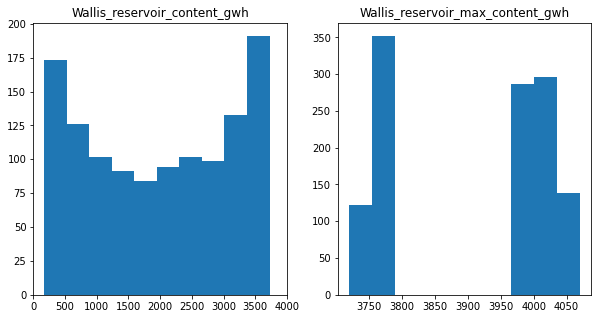

In [ ]:
# Histogram for Wallis_speicherinhalt_gwh and Wallis_max_speicherinhalt_gwh

Wallis_speicherinhalt_gwh = df_water_reservoir["Wallis_reservoir_content_gwh"]
Wallis_max_speicherinhalt_gwh = df_water_reservoir["Wallis_reservoir_max_content_gwh"]

# Creating histogram
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

ax1.hist(Wallis_speicherinhalt_gwh)
ax1.set_title("Wallis_reservoir_content_gwh")
ax1.set_xlim([0,4000])
#ax1.set_ylim([0,15])

ax2.hist(Wallis_max_speicherinhalt_gwh)
ax2.set_title("Wallis_reservoir_max_content_gwh")
#ax2.set_xlim([0,5000])
#ax2.set_ylim([0,4000])

# Show plot
plt.show()

**Interpretation**: The histogram shows a distribution which is low in the center and highest in the left and right corner. Furthermore we interpret the max value as the capacity of the reservoir.

In [ ]:
df_water_reservoir.filter(["Wallis_reservoir_content_gwh", "Wallis_reservoir_max_content_gwh"])

Wallis_reservoir_content_gwh  Wallis_reservoir_max_content_gwh
0                             2037                              3770
1                             1945                              3770
2                             1733                              3770
3                             1584                              3770
4                             1414                              3770
...                            ...                               ...
1190                          3613                              4070
1191                          3657                              4070
1192                          3628                              4070
1193                          3637                              4070
1194                          3608                              4070

[1195 rows x 2 columns]

**Line Charts**

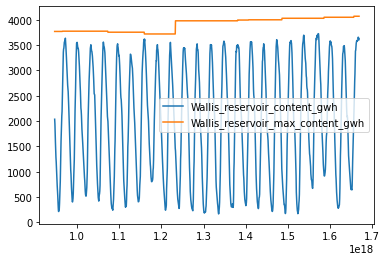

In [ ]:
# Line Charts: Max Reservoir capacity vs Actual content in the water reservoir
Wallis_reservoir_content_gwh = df_water_reservoir["Wallis_reservoir_content_gwh"].values.tolist()
Wallis_reservoir_max_content_gwh = df_water_reservoir["Wallis_reservoir_max_content_gwh"].values.tolist()
data = {"Wallis_reservoir_content_gwh":Wallis_reservoir_content_gwh, "Wallis_reservoir_max_content_gwh":Wallis_reservoir_max_content_gwh}

index = df_water_reservoir["Date"].values.tolist()

df_lines= pd.DataFrame(data=data, index=index);
lines = df_lines.plot.line()

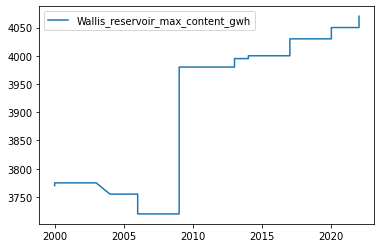

In [ ]:
# Development of Max Reservoir capacity
Wallis_reservoir_max_content_gwh = df_water_reservoir["Wallis_reservoir_max_content_gwh"].values.tolist()
data = {"Wallis_reservoir_max_content_gwh":Wallis_reservoir_max_content_gwh}

index = df_water_reservoir["Year"].values.tolist()

df_lines= pd.DataFrame(data=data, index=index);
lines = df_lines.plot.line()

**Interpretation**: The maximum capacity was never exceeded, but at the point 1.2 it was very tight. This was most likely the reason the reservoir cacapity for Wallis was extended.

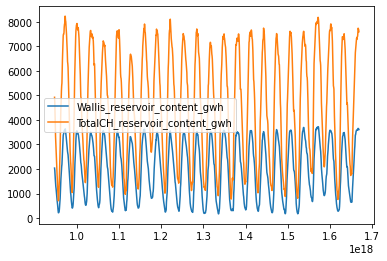

In [ ]:
# Line Charts : Total Vs Wallis reservoir content
Wallis_reservoir_content_gwh = df_water_reservoir["Wallis_reservoir_content_gwh"].values.tolist()
TotalCH_reservoir_content_gwh = df_water_reservoir["TotalCH_reservoir_content_gwh"].values.tolist()
data = {"Wallis_reservoir_content_gwh":Wallis_reservoir_content_gwh, "TotalCH_reservoir_content_gwh":TotalCH_reservoir_content_gwh}

index = df_water_reservoir["Date"].values.tolist()

df_lines= pd.DataFrame(data=data, index=index);
lines = df_lines.plot.line()

**Interpretation**: Wallis reservoir content show similar periodical behaviour than the Total reservoir content.

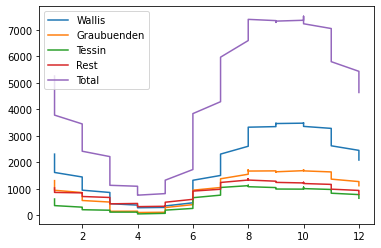

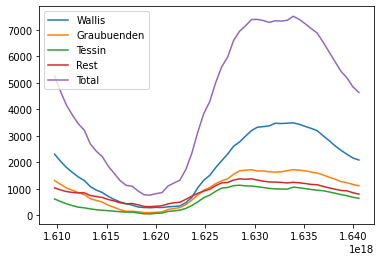

In [ ]:
# Line Chart: Zoom in to one Year (2021)

df_water_reservoir_one_year = df_water_reservoir.query("Year == 2021")

Wallis_reservoir_content_gwh = df_water_reservoir_one_year["Wallis_reservoir_content_gwh"].values.tolist()
Graubuenden_reservoir_content_gwh = df_water_reservoir_one_year["Graubuenden_reservoir_content_gwh"].values.tolist()
Tessin_reservoir_content_gwh = df_water_reservoir_one_year["Tessin_reservoir_content_gwh"].values.tolist()
RestCH_reservoir_content_gwh = df_water_reservoir_one_year["RestCH_reservoir_content_gwh"].values.tolist()
TotalCH_reservoir_content_gwh = df_water_reservoir_one_year["TotalCH_reservoir_content_gwh"].values.tolist()
data = {"Wallis":Wallis_reservoir_content_gwh,"Graubuenden" : Graubuenden_reservoir_content_gwh, "Tessin": Tessin_reservoir_content_gwh, "Rest" : RestCH_reservoir_content_gwh, "Total":TotalCH_reservoir_content_gwh,}

#  indexing
index = df_water_reservoir_one_year["Month"].values.tolist()
index_cont = df_water_reservoir_one_year["Date"].values.tolist()

# with discrete index
df_lines1= pd.DataFrame(data=data, index=index)
lines = df_lines1.plot.line()

# with continious index
df_lines2= pd.DataFrame(data=data, index=index_cont)
lines = df_lines2.plot.line()


**Interpretation**
- All curves shows the same periodic / quadratic behaviour with a peak in September and and a lowest point in April.
- Wallis has the highest slope.  

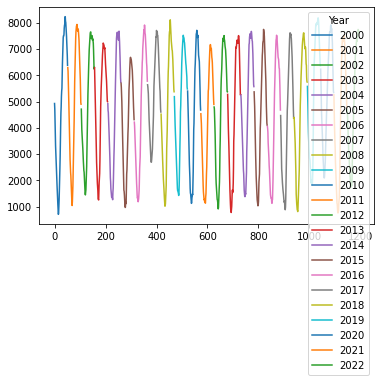

In [ ]:
# Are there any years where the Total and Wallis Curve looks different?

# Line Chart: All years with Total
df_water_reservoir_pivot = df_water_reservoir.pivot(values='TotalCH_reservoir_content_gwh', columns='Year')
#print(df_water_reservoir_pivot.head(5))
df_water_reservoir_pivot.plot()

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
            2022],
           dtype='int64', name='Year')


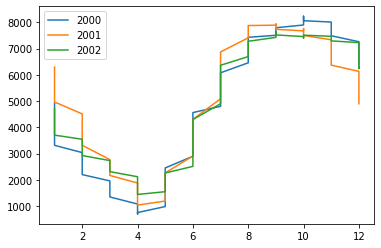

In [ ]:
print(df_water_reservoir_pivot.columns)
index = df_water_reservoir["Month"].values.tolist()

reservoir_content_2000 = df_water_reservoir_pivot[2000].values.tolist()
reservoir_content_2001 = df_water_reservoir_pivot[2001].values.tolist()
reservoir_content_2002 = df_water_reservoir_pivot[2002].values.tolist()
reservoir_content_2003 = df_water_reservoir_pivot[2003].values.tolist()
reservoir_content_2004 = df_water_reservoir_pivot[2004].values.tolist()

data = {"2000":reservoir_content_2000,"2001" : reservoir_content_2001, "2002": reservoir_content_2002}


df_lines1= pd.DataFrame(data=data, index=index)
lines = df_lines1.plot.line()


**Interpretation**: The Years dont differ much in terms of the periodic behaviour.

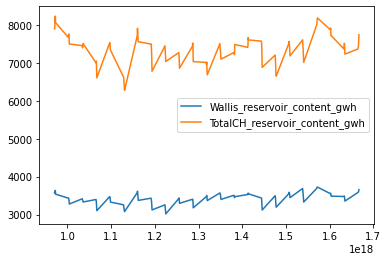

In [ ]:
# Line Chart: Zoom in to one month

df_water_reservoir_one_year = df_water_reservoir.query("Year == 2021")
df_water_reservoir_one_year = df_water_reservoir.query("Month == 10")

Wallis_reservoir_content_gwh = df_water_reservoir_one_year["Wallis_reservoir_content_gwh"].values.tolist()
TotalCH_reservoir_content_gwh = df_water_reservoir_one_year["TotalCH_reservoir_content_gwh"].values.tolist()
data = {"Wallis_reservoir_content_gwh":Wallis_reservoir_content_gwh, "TotalCH_reservoir_content_gwh":TotalCH_reservoir_content_gwh}

index_cont = df_water_reservoir_one_year["Date"].values.tolist()

# with continious index
df_lines2= pd.DataFrame(data=data, index=index_cont)
lines = df_lines2.plot.line()



**Interpretation**: Wallis Reservoir content shows similar behaviour than Total CH Reservoir.

**Scatter Plots**

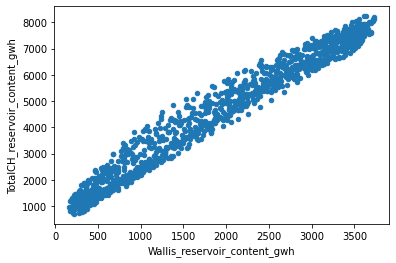

In [ ]:
#  Scatter Plot: Wallis vs Total
df_water_reservoir.plot.scatter("Wallis_reservoir_content_gwh", "TotalCH_reservoir_content_gwh")

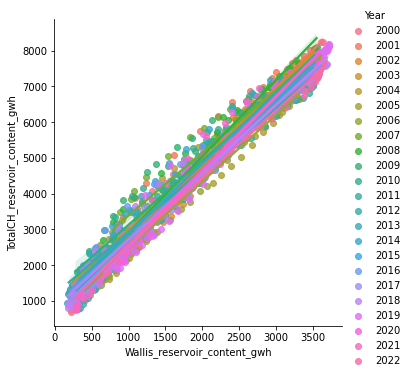

In [ ]:
# With a fitting line
sns.lmplot(x="Wallis_reservoir_content_gwh", y="TotalCH_reservoir_content_gwh", data=df_water_reservoir, hue = 'Year',);

Looks like a **strong** positive linear relationship

**Pearsons Correlation**

In [ ]:
# Correlation plot: Wallis Reservoir vs Total CH
Wallis_reservoir_content_gwh = df_water_reservoir["Wallis_reservoir_content_gwh"].values.tolist()
TotalCH_reservoir_content_gwh = df_water_reservoir["TotalCH_reservoir_content_gwh"].values.tolist()

Pearson = scipy.stats.pearsonr(Wallis_reservoir_content_gwh, TotalCH_reservoir_content_gwh)[0]  
print("Pearsons Correlation is:", Pearson)

Pearsons Correlation is: 0.9838907947866965


Indeed: Pearson's correlation confirms this

In [ ]:
# Correlation matrix of all:
cor_matrix = df_water_reservoir.corr()
round(cor_matrix,2)

Wallis_reservoir_content_gwh  \
Wallis_reservoir_content_gwh                                   1.00   
Graubuenden_reservoir_content_gwh                              0.92   
Tessin_reservoir_content_gwh                                   0.88   
RestCH_reservoir_content_gwh                                   0.95   
TotalCH_reservoir_content_gwh                                  0.98   
Wallis_reservoir_max_content_gwh                               0.01   
Graubuenden_reservoir_max_content_gwh                          0.08   
Tessin_reservoir_max_content_gwh                               0.08   
RestCH_reservoir_max_content_gwh                              -0.06   
TotalCH_reservoir_max_content_gwh                              0.02   
Year                                                           0.02   
Month                                                          0.68   

                                       Graubuenden_reservoir_content_gwh  \
Wallis_reservoir_content_gwh                                        0.92   
Graubuenden_reservoir_content_gwh                                   1.00   
Tessin_reservoir_content_gwh                                        0.96   
RestCH_reservoir_content_gwh                                        0.95   
TotalCH_reservoir_content_gwh                                       0.97   
Wallis_reservoir_max_content_gwh                                   -0.06   
Graubuenden_reservoir_max_content_gwh                               0.05   
Tessin_reservoir_max_content_gwh                                    0.01   
RestCH_reservoir_max_content_gwh                                   -0.03   
TotalCH_reservoir_max_content_gwh                                  -0.05   
Year                                                               -0.05   
Month                                                               0.67   

                                       Tessin_reservoir_content_gwh  \
Wallis_reservoir_content_gwh                                   0.88   
Graubuenden_reservoir_content_gwh                              0.96   
Tessin_reservoir_content_gwh                                   1.00   
RestCH_reservoir_content_gwh                                   0.91   
TotalCH_reservoir_content_gwh                                  0.94   
Wallis_reservoir_max_content_gwh                              -0.05   
Graubuenden_reservoir_max_content_gwh                          0.05   
Tessin_reservoir_max_content_gwh                              -0.05   
RestCH_reservoir_max_content_gwh                              -0.10   
TotalCH_reservoir_max_content_gwh                             -0.05   
Year                                                          -0.07   
Month                                                          0.66   

                                       RestCH_reservoir_content_gwh  \
Wallis_reservoir_content_gwh                                   0.95   
Graubuenden_reservoir_content_gwh                              0.95   
Tessin_reservoir_content_gwh                                   0.91   
RestCH_reservoir_content_gwh                                   1.00   
TotalCH_reservoir_content_gwh                                  0.98   
Wallis_reservoir_max_content_gwh                              -0.05   
Graubuenden_reservoir_max_content_gwh                          0.05   
Tessin_reservoir_max_content_gwh                               0.04   
RestCH_reservoir_max_content_gwh                              -0.04   
TotalCH_reservoir_max_content_gwh                             -0.04   
Year                                                          -0.03   
Month                                                          0.68   

                                       TotalCH_reservoir_content_gwh  \
Wallis_reservoir_content_gwh                                    0.98   
Graubuenden_reservoir_content_gwh                               0.97   
Tessin_reservoir_content_gwh                                  

**Interpretation**: One can clearly see that there is a strong positive linear relationship between Valais to Graubuenden, Ticino, Rest and Total. This means that if the reservoir water level in Valais increases, the reservoir water level also increases in Graubuenden, Ticino and the rest. If the water level in Valis decreases the water level also decreases in the other cantons.

**Pie Chart**

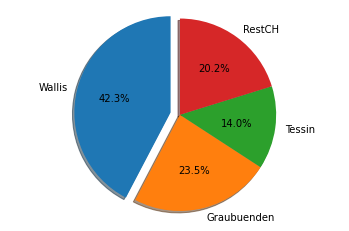

In [ ]:
# Pie Chart with the sums of the water reservoir
Wallis_reservoir_content_gwh_sum = df_water_reservoir["Wallis_reservoir_content_gwh"].sum()
Graubuenden_reservoir_content_gwh_sum = df_water_reservoir["Graubuenden_reservoir_content_gwh"].sum()
Tessin_reservoir_content_gwh_sum = df_water_reservoir["Tessin_reservoir_content_gwh"].sum()
RestCH_reservoir_content_gwh_sum = df_water_reservoir["RestCH_reservoir_content_gwh"].sum()
TotalCH_reservoir_content_gwh_sum = df_water_reservoir["TotalCH_reservoir_content_gwh"].sum()

# In % of Total
x1 = Wallis_reservoir_content_gwh_sum/TotalCH_reservoir_content_gwh_sum
x2 = Graubuenden_reservoir_content_gwh_sum/TotalCH_reservoir_content_gwh_sum
x3 = Tessin_reservoir_content_gwh_sum/TotalCH_reservoir_content_gwh_sum
x4 = RestCH_reservoir_content_gwh_sum/TotalCH_reservoir_content_gwh_sum

sizes = [x1,x2,x3,x4]

labels = 'Wallis', 'Graubuenden', 'Tessin', 'RestCH'
explode = (0.1, 0, 0, 0)  # it will take out (highlight) one part of the plot --> Wallis in this case

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90) #shadow true makes it looks nicer, autopct is for formatting the legend, startangle says on which position wallis will start
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In total wallis has the most water reservoir capacity of the switzerland.

**Boxplot**

In [ ]:
# New data structure to use a boxplot
Wallis_reservoir_content_gwh = df_water_reservoir["Wallis_reservoir_content_gwh"].values.tolist()
Graubuenden_reservoir_content_gwh = df_water_reservoir["Graubuenden_reservoir_content_gwh"].values.tolist()
Tessin_reservoir_content_gwh = df_water_reservoir["Tessin_reservoir_content_gwh"].values.tolist()
RestCH_reservoir_content_gwh = df_water_reservoir["RestCH_reservoir_content_gwh"].values.tolist()
TotalCH_reservoir_content_gwh = df_water_reservoir["TotalCH_reservoir_content_gwh"].values.tolist()

Wallis = ["Wallis"] * len(Wallis_reservoir_content_gwh)
Graubuenden = ["Graubuenden"] * len(Graubuenden_reservoir_content_gwh)
Tessin = ["Tessin"] * len(Tessin_reservoir_content_gwh)
RestCH = ["RestCH"] * len(RestCH_reservoir_content_gwh)


d1 = {'Reservoir_Content': Wallis_reservoir_content_gwh, "Region" : Wallis}
d2 = {'Reservoir_Content': Graubuenden_reservoir_content_gwh, "Region" : Graubuenden}
d3 = {'Reservoir_Content': Tessin_reservoir_content_gwh, "Region" : Tessin}
d4 = {'Reservoir_Content': RestCH_reservoir_content_gwh, "Region" : RestCH}

df1 = pd.DataFrame(data=d1)
df2 = pd.DataFrame(data=d2)
df3 = pd.DataFrame(data=d3)
df4 = pd.DataFrame(data=d4)

df_water_reservoir_boxplot = pd.concat([df1, df2, df3, df4])

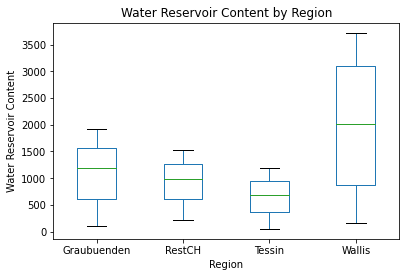

In [ ]:
# Boxplots for each 
ax = df_water_reservoir_boxplot.boxplot(by ='Region', column =['Reservoir_Content'], grid = False)
plt.title("Water Reservoir Content by Region")
plt.suptitle('')
ax.set_xlabel("Region");
ax.set_ylabel("Water Reservoir Content");
plt.show()

**Interpretation**: No outliers detected according to the boxplot. Wallis has the widest spread in the data. Wallis has the highest median in comparison to the others.

### Climate Dataset (Grächen)

#### Development and Distribution of measured temperature

Now the development over time (2000 - 2021) of the average daily temperature measured at the station in Grächen is plotted. A clear seasonality can be detected between summer and winter.

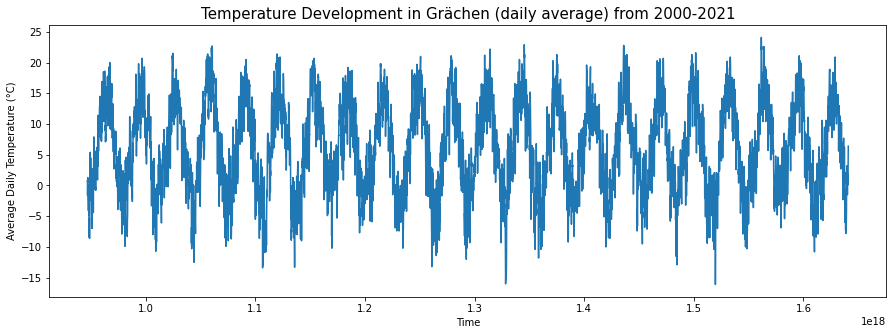

Maximum measured temperature: 24.1
Minimum measured temperature: -16.1
Average measured temperature: 6.2514001244555075
Standard Average of measured temperature: 7.303598471192421


In [ ]:
# Define the values
data_temp = df_weather_2000["air_temperature_2m_above_surface_daily_avg"].values.tolist()
data = {"Average Temperature in Celsius": data_temp}
index_temp = df_weather_2000["date"].values.tolist()

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(15,5))
ax1.plot(index_temp, data_temp)
ax1.set_title("Temperature Development in Grächen (daily average) from 2000-2021",
              size = 15)
ax1.set_xlabel("Time")
ax1.set_ylabel("Average Daily Temperature (°C)")
plt.show();

print("Maximum measured temperature:", max(data_temp))
print("Minimum measured temperature:", min(data_temp))
print("Average measured temperature:", statistics.mean(data_temp))
print("Standard Average of measured temperature:", statistics.stdev(data_temp))

Now the distribution of the measured temperature is examined. 

In [ ]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

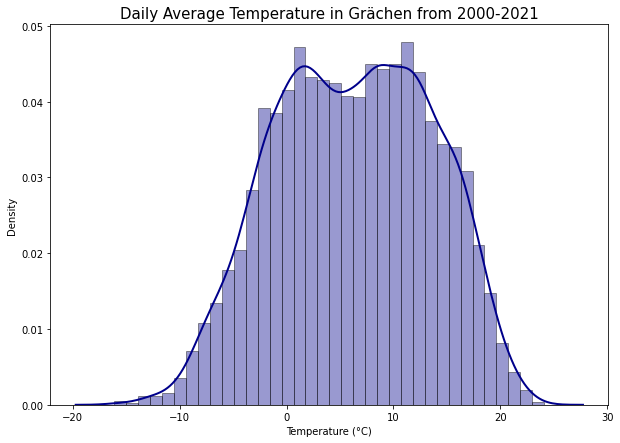

In [ ]:
# Set the figure attributes and shapes
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7))

# Define the plot --> seaborn-plot
ax1 = sns.distplot(df_weather_2000["air_temperature_2m_above_surface_daily_avg"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

ax1.set_title("Daily Average Temperature in Grächen from 2000-2021", size = 15)
ax1.set_xlabel("Temperature (°C)")
plt.show();

#### Development and Distribution of the solar radiation

The assumption for the different variables contained in the weather dataset is, that the temperature, solar radiation, rain and the snow-height might have an influence on the reservoir content. Higher temperature, especially during the winter periods but also in general leads to more glacier water, since the glaciers are melting. Furthermore, more rain is having the same effect. An additional effect of the rain is also that the rain water is falling directly in the reservoir or is making its way through the surrounding hills into the reservoir. The height of the snow might also have an influnence on the reservoir amount. We assume an inverse relationship. If the snow-height is decreasing (melting) we assume the reservoir amount to increase.

The measurement for the solar radition are only available from the 01.06.2013 onwards, therefore the dataframe need to be truncated once again.

In [ ]:
df_weather_2013 = df_weather_2000[df_weather_2000["date"] > "2013-06-01"]

In [ ]:
df_weather_2013.head(5)

station/location       date  solar_radiation_daily_avg  \
54574              GRC 2013-06-02                      362.0   
54575              GRC 2013-06-03                      361.0   
54576              GRC 2013-06-04                      337.0   
54577              GRC 2013-06-05                      347.0   
54578              GRC 2013-06-06                      377.0   

       snowheight_measure_6am  cloudiness_daily_avg  air_pressure_daily_avg  \
54574                     0.0                  38.0                   839.1   
54575                     0.0                  25.0                   839.6   
54576                     0.0                  21.0                   838.7   
54577                     0.0                  25.0                   839.6   
54578                     0.0                  17.0                   841.3   

       rain_sum  solar_radiation_duration_daily_sum  \
54574       0.0                               640.0   
54575       0.0                               554.0   
54576       0.0                               524.0   
54577       0.0                               565.0   
54578       0.0                               705.0   

       air_temperature_2m_above_surface_daily_avg  \
54574                                         8.1   
54575                                         7.9   
54576                                         8.8   
54577                                        11.2   
54578                                        12.9   

       air_temperature_2m_above_surface_daily_min  \
54574                                         3.4   
54575                                         4.0   
54576                                         3.3   
54577                                         5.8   
54578                                         7.2   

       air_temperature_2m_above_surface_daily_max  \
54574                                        14.6   
54575                                        14.0   
54576                                        15.9   
54577                                        17.8   
54578                                        19.2   

       relative_humidity_2m_above_surface_daily_avg  
54574                                          70.6  
54575                                          65.4  
54576                                          68.7  
54577                                          60.2  
54578                                          52.6

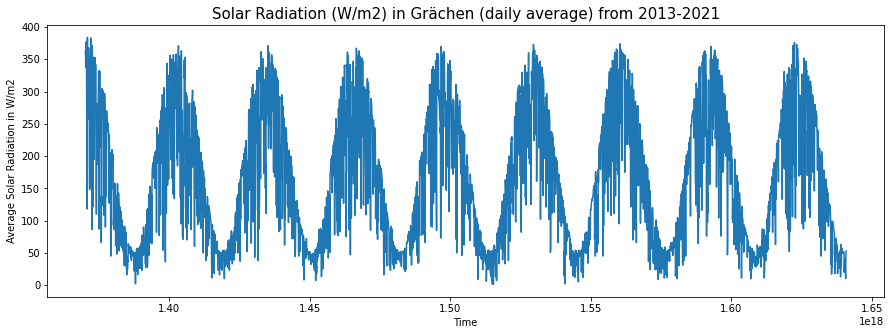

Maximum Solar Radiation (W/m2): 384.0
Minimum Solar Radiation (W/m2): 1.0
Average Solar Radiation (W/m2): 162.08867623604465
Standard Average of Solar Radiation (W/m2): 100.27812209182859


In [ ]:
# Define the values
data_solar = df_weather_2013["solar_radiation_daily_avg"].values.tolist()
data = {"Solar Radiation in Minutes": data_solar}
index_solar = df_weather_2013["date"].values.tolist()

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(15,5))
ax1.plot(index_solar, data_solar)
ax1.set_title("Solar Radiation (W/m2) in Grächen (daily average) from 2013-2021",
              size = 15)
ax1.set_xlabel("Time")
ax1.set_ylabel("Average Solar Radiation in W/m2")
plt.show();

print("Maximum Solar Radiation (W/m2):", max(data_solar))
print("Minimum Solar Radiation (W/m2):", min(data_solar))
print("Average Solar Radiation (W/m2):", statistics.mean(data_solar))
print("Standard Average of Solar Radiation (W/m2):", statistics.stdev(data_solar))

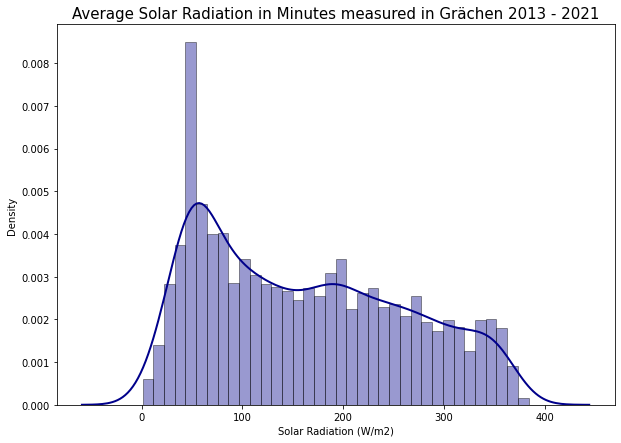

In [ ]:
# Set the figure attributes and shapes
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7))

# Define the plot --> seaborn-plot
ax1 = sns.distplot(df_weather_2013["solar_radiation_daily_avg"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

ax1.set_title("Average Solar Radiation in Minutes measured in Grächen 2013 - 2021", size = 15)
ax1.set_xlabel("Solar Radiation (W/m2)")
plt.show();

#### Development and Distribution of Rain

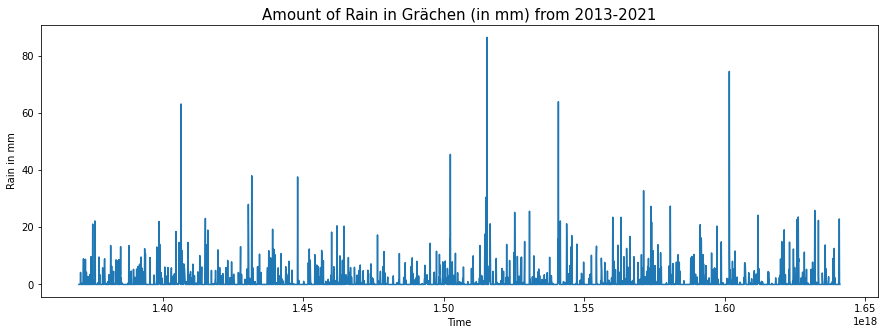

Maximum Rain in mm: 86.4
Minimum Rain in mm: 0.0
Average Rain in mm: 1.4634130781499202
Standard Average of Rain in mm: 4.458641877291491


In [ ]:
# Define the values
data_rain = df_weather_2013["rain_sum"].values.tolist()
data = {"Rain in mm": data_rain}
index_rain = df_weather_2013["date"].values.tolist()

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(15,5))
ax1.plot(index_rain, data_rain)
ax1.set_title("Amount of Rain in Grächen (in mm) from 2013-2021",
              size = 15)
ax1.set_xlabel("Time")
ax1.set_ylabel("Rain in mm")
plt.show();

print("Maximum Rain in mm:", max(data_rain))
print("Minimum Rain in mm:", min(data_rain))
print("Average Rain in mm:", statistics.mean(data_rain))
print("Standard Average of Rain in mm:", statistics.stdev(data_rain))

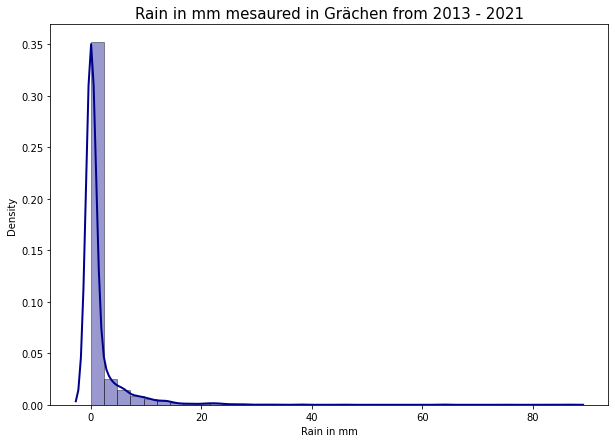

In [ ]:
# Set the figure attributes and shapes
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7))

# Define the plot --> seaborn-plot
ax1 = sns.distplot(df_weather_2013["rain_sum"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

ax1.set_title("Rain in mm mesaured in Grächen from 2013 - 2021", size = 15)
ax1.set_xlabel("Rain in mm")
plt.show();

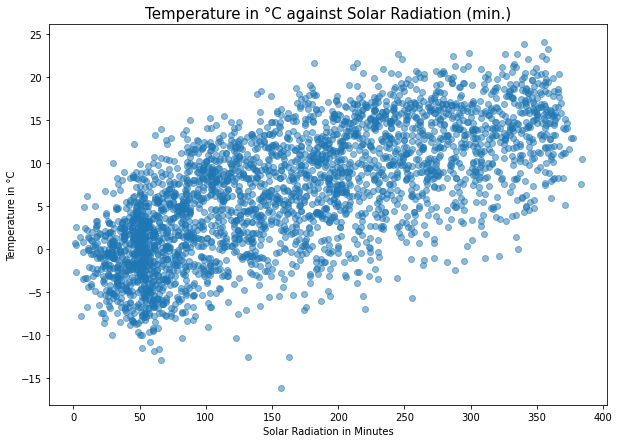

In [ ]:
# Define the values / variables
solar = df_weather_2013["solar_radiation_daily_avg"].values.tolist()
temperature = df_weather_2013["air_temperature_2m_above_surface_daily_avg"].values.tolist()

# Define the plot
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7))

# Scatterplot: solar radiation vs temperature
ax1.scatter(solar,
            temperature,
            alpha=0.5)
ax1.set_title("Temperature in °C against Solar Radiation (min.)",
              size = 15)
ax1.set_xlabel("Solar Radiation in Minutes")
ax1.set_ylabel("Temperature in °C")
plt.show();

#### Development and Distribution of Snowheight

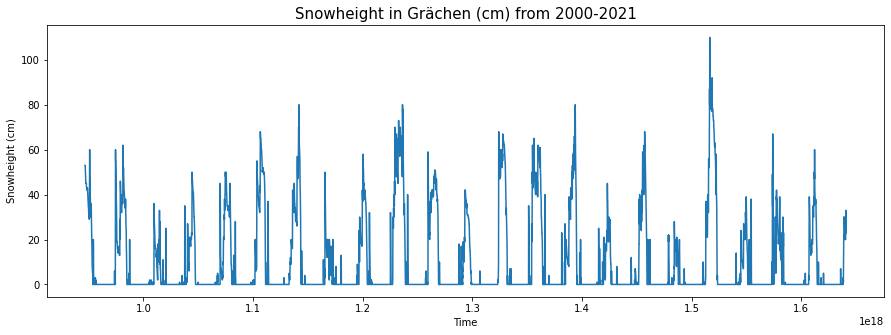

Maximum Snowheight (cm): 110.0
Minimum Snowheight (cm): 0.0
Average Snowheight (cm): 9.299066583696328
Standard Average of Snowheight (cm): 17.52274507167251


In [ ]:
# Define the values
data_snow = df_weather_2000["snowheight_measure_6am"].values.tolist()
data = {"Snowheight in cm": data_snow}
index_snow = df_weather_2000["date"].values.tolist()

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(15,5))
ax1.plot(index_snow, data_snow)
ax1.set_title("Snowheight in Grächen (cm) from 2000-2021",
              size = 15)
ax1.set_xlabel("Time")
ax1.set_ylabel("Snowheight (cm)")
plt.show();

print("Maximum Snowheight (cm):", max(data_snow))
print("Minimum Snowheight (cm):", min(data_snow))
print("Average Snowheight (cm):", statistics.mean(data_snow))
print("Standard Average of Snowheight (cm):", statistics.stdev(data_snow))

### Climate Dataset (St.Bernard)

#### Development and Distribution of measured temperature

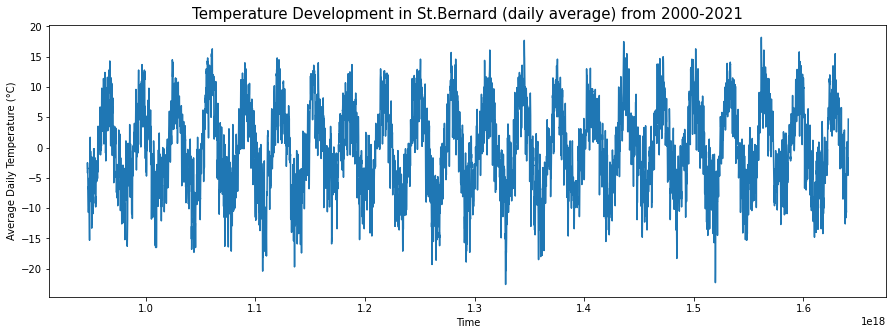

Maximum measured temperature: 18.2
Minimum measured temperature: -22.6
Average measured temperature: 0.04200373366521469
Standard Average of measured temperature: 6.995111150115878


In [ ]:
# Define the values
data_temp = df_weather_stbernard_2000["air_temperature_2m_above_surface_daily_avg"].values.tolist()
data = {"Average Temperature in Celsius": data_temp}
index_temp = df_weather_stbernard_2000["date"].values.tolist()

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(15,5))
ax1.plot(index_temp, data_temp)
ax1.set_title("Temperature Development in St.Bernard (daily average) from 2000-2021",
              size = 15)
ax1.set_xlabel("Time")
ax1.set_ylabel("Average Daily Temperature (°C)")
plt.show();

print("Maximum measured temperature:", max(data_temp))
print("Minimum measured temperature:", min(data_temp))
print("Average measured temperature:", statistics.mean(data_temp))
print("Standard Average of measured temperature:", statistics.stdev(data_temp))

### Combined Data

#### Getting Information about Water Reservoirs from Wikipedia

In [ ]:
stauseen_wallis = pd.read_html("https://de.wikipedia.org/wiki/Liste_der_Speicherseen_in_der_Schweiz")

In [ ]:
df_stauseen = stauseen_wallis[0]

In [ ]:
df_stauseen.head(5)

Name        Kanton / Land  Gesamtinhaltin Mio. m³  \
0        Lac des Dix               Wallis                     401   
1      Lac d’Emosson               Wallis                     227   
2  Lac de la Gruyère             Freiburg                     220   
3   Lac de Mauvoisin               Wallis                     211   
4        Lago di Lei  Italien, Graubünden                     197   

   Höhem ü. M.  Flächein km²  max. Tiefein Meter Name der Talsperre  \
0         2365          3.65                 227     Grande Dixence   
1         1930          3.27                 161            Emosson   
2          677          9.28                  75            Rossens   
3         1961          2.08                 180          Mauvoisin   
4         1931          4.10                 133       Valle di Lei   

    Staumauertyp  Baujahr  Höhein Meter  
0  Gewichtsmauer   1961.0         285.0  
1     Bogenmauer   1974.0         180.0  
2     Bogenmauer   1947.0          83.0  
3     Bogenmauer   1957.0         250.0  
4     Bogenmauer   1961.0         141.0

In [ ]:
df_stauseen.dtypes

Name                       object
Kanton / Land              object
Gesamtinhaltin Mio. m³      int64
Höhem ü. M.                 int64
Flächein km²              float64
max. Tiefein Meter          int64
Name der Talsperre         object
Staumauertyp               object
Baujahr                   float64
Höhein Meter              float64
dtype: object

In [ ]:
df_stauseen_wallis = df_stauseen[df_stauseen["Kanton / Land"] == "Wallis"]

In [ ]:
df_stauseen_wallis.shape

(14, 10)

In [ ]:
height = df_stauseen_wallis.iloc[:,3].values.tolist()
statistics.mean(height)

2039.7142857142858

In [ ]:
df_measuring_stations_wallis = df_measuring_stations[df_measuring_stations["Canton"] == "VS"]
df_measuring_stations_wallis.head(5)

Station station/location         WIGOS-ID  Data since  \
10                  Grächen              GRC  0-20000-0-06728  01.01.1864   
12  Col du Grand St-Bernard              GSB  0-20000-0-06717  01.01.1818   
14             Jungfraujoch              JUN  0-20000-0-06730  01.01.1933   
26                     Sion              SIO  0-20000-0-06720  01.01.1864   

    Station height m. a. sea level  CoordinatesE  CoordinatesN   Latitude  \
10                          1605.0     2630738.0     1116062.0  46.195314   
12                          2472.0     2579191.0     1079754.0  45.869092   
14                          3571.0     2641939.0     1155287.0  46.547556   
26                           482.0     2591633.0     1118584.0  46.218650   

    Longitude              Climate region Canton  \
10   7.836822                      Valais     VS   
12   7.170683           Alpine south side     VS   
14   7.985444  Western Alpine north slope     VS   
26   7.330203                      Valais     VS   

                   URL Previous years (verified data)  \
10  https://data.geo.admin.ch/ch.meteoschweiz.klim...   
12  https://data.geo.admin.ch/ch.meteoschweiz.klim...   
14  https://data.geo.admin.ch/ch.meteoschweiz.klim...   
26  https://data.geo.admin.ch/ch.meteoschweiz.klim...   

                                     URL Current year  
10  https://data.geo.admin.ch/ch.meteoschweiz.klim...  
12  https://data.geo.admin.ch/ch.meteoschweiz.klim...  
14  https://data.geo.admin.ch/ch.meteoschweiz.klim...  
26  https://data.geo.admin.ch/ch.meteoschweiz.klim...

#### Merge Dataframes (Grächen & Water Reservoir)

In [ ]:
# Combine the two dataframes
df_combined = pd.merge(df_water_reservoir, df_weather_2000, left_on = "Date", right_on = "date", how = "inner")

In [ ]:
# Check success of merge
df_combined.head(5)

Date  Wallis_reservoir_content_gwh  Graubuenden_reservoir_content_gwh  \
0 2000-01-03                          2037                               1226   
1 2000-01-10                          1945                               1175   
2 2000-01-17                          1733                               1063   
3 2000-01-24                          1584                                940   
4 2000-01-31                          1414                                803   

   Tessin_reservoir_content_gwh  RestCH_reservoir_content_gwh  \
0                           758                           904   
1                           720                           868   
2                           651                           777   
3                           591                           674   
4                           517                           581   

   TotalCH_reservoir_content_gwh  Wallis_reservoir_max_content_gwh  \
0                           4925                              3770   
1                           4708                              3770   
2                           4224                              3770   
3                           3789                              3770   
4                           3315                              3770   

   Graubuenden_reservoir_max_content_gwh  Tessin_reservoir_max_content_gwh  \
0                                   1905                              1225   
1                                   1905                              1225   
2                                   1905                              1225   
3                                   1905                              1225   
4                                   1905                              1225   

   RestCH_reservoir_max_content_gwh  ...  solar_radiation_daily_avg  \
0                              1600  ...                        0.0   
1                              1600  ...                        0.0   
2                              1600  ...                        0.0   
3                              1600  ...                        0.0   
4                              1600  ...                        0.0   

   snowheight_measure_6am  cloudiness_daily_avg air_pressure_daily_avg  \
0                    53.0                   8.0                    0.0   
1                    45.0                  38.0                    0.0   
2                    43.0                  25.0                    0.0   
3                    42.0                  63.0                    0.0   
4                    40.0                  38.0                    0.0   

  rain_sum  solar_radiation_duration_daily_sum  \
0      0.0                                 0.0   
1      0.0                                 0.0   
2      0.0                                 0.0   
3      0.5                                 0.0   
4      0.0                                 0.0   

   air_temperature_2m_above_surface_daily_avg  \
0                                         0.5   
1                                        -1.6   
2                                        -3.6   
3                                        -7.2   
4                                         2.5   

   air_temperature_2m_above_surface_daily_min  \
0                                        -4.0   
1                                        -4.5   
2                                        -7.0   
3                                       -10.0   
4                                        -0.5   

   air_temperature_2m_above_surface_daily_max  \
0                                         6.0   
1                                         3.0   
2                                         1.5   
3                                        -2.5   
4                                         8.0   

   relative_humidity_2m_above_surface_daily_avg  
0                                          39.2  
1                                          66.2  
2                               

In [ ]:
# Cut the columns which we don't need
df_combined.drop(columns = ["Graubuenden_reservoir_content_gwh",
                            "Tessin_reservoir_content_gwh",
                            "RestCH_reservoir_content_gwh",
                            "TotalCH_reservoir_content_gwh",
                            "Graubuenden_reservoir_max_content_gwh",
                            "Tessin_reservoir_max_content_gwh",
                            "RestCH_reservoir_max_content_gwh",
                            "TotalCH_reservoir_max_content_gwh",
                            "date"], inplace = True)

In [ ]:
df_combined.head(5)

Date  Wallis_reservoir_content_gwh  Wallis_reservoir_max_content_gwh  \
0 2000-01-03                          2037                              3770   
1 2000-01-10                          1945                              3770   
2 2000-01-17                          1733                              3770   
3 2000-01-24                          1584                              3770   
4 2000-01-31                          1414                              3770   

   Year  Month station/location  solar_radiation_daily_avg  \
0  2000      1              GRC                        0.0   
1  2000      1              GRC                        0.0   
2  2000      1              GRC                        0.0   
3  2000      1              GRC                        0.0   
4  2000      1              GRC                        0.0   

   snowheight_measure_6am  cloudiness_daily_avg  air_pressure_daily_avg  \
0                    53.0                   8.0                     0.0   
1                    45.0                  38.0                     0.0   
2                    43.0                  25.0                     0.0   
3                    42.0                  63.0                     0.0   
4                    40.0                  38.0                     0.0   

   rain_sum  solar_radiation_duration_daily_sum  \
0       0.0                                 0.0   
1       0.0                                 0.0   
2       0.0                                 0.0   
3       0.5                                 0.0   
4       0.0                                 0.0   

   air_temperature_2m_above_surface_daily_avg  \
0                                         0.5   
1                                        -1.6   
2                                        -3.6   
3                                        -7.2   
4                                         2.5   

   air_temperature_2m_above_surface_daily_min  \
0                                        -4.0   
1                                        -4.5   
2                                        -7.0   
3                                       -10.0   
4                                        -0.5   

   air_temperature_2m_above_surface_daily_max  \
0                                         6.0   
1                                         3.0   
2                                         1.5   
3                                        -2.5   
4                                         8.0   

   relative_humidity_2m_above_surface_daily_avg  
0                                          39.2  
1                                          66.2  
2                                          51.4  
3                                          78.2  
4                                          75.1

#### Merge Dataframes (St.Bernard & Water Reservoir)

In [ ]:
# Combine the two dataframes
df_combined2 = pd.merge(df_water_reservoir, df_weather_stbernard_2000, left_on = "Date", right_on = "date", how = "inner")

In [ ]:
# Check success of merge
df_combined2.head(5)

Date  Wallis_reservoir_content_gwh  Graubuenden_reservoir_content_gwh  \
0 2000-01-03                          2037                               1226   
1 2000-01-10                          1945                               1175   
2 2000-01-17                          1733                               1063   
3 2000-01-24                          1584                                940   
4 2000-01-31                          1414                                803   

   Tessin_reservoir_content_gwh  RestCH_reservoir_content_gwh  \
0                           758                           904   
1                           720                           868   
2                           651                           777   
3                           591                           674   
4                           517                           581   

   TotalCH_reservoir_content_gwh  Wallis_reservoir_max_content_gwh  \
0                           4925                              3770   
1                           4708                              3770   
2                           4224                              3770   
3                           3789                              3770   
4                           3315                              3770   

   Graubuenden_reservoir_max_content_gwh  Tessin_reservoir_max_content_gwh  \
0                                   1905                              1225   
1                                   1905                              1225   
2                                   1905                              1225   
3                                   1905                              1225   
4                                   1905                              1225   

   RestCH_reservoir_max_content_gwh  ...  solar_radiation_daily_avg  \
0                              1600  ...                       37.0   
1                              1600  ...                       58.0   
2                              1600  ...                       35.0   
3                              1600  ...                       45.0   
4                              1600  ...                       90.0   

   snowheight_measure_6am  cloudiness_daily_avg air_pressure_daily_avg  \
0                     0.0                   0.0                  760.2   
1                     0.0                  33.0                  756.5   
2                     0.0                  17.0                  756.5   
3                     0.0                  58.0                  742.0   
4                     0.0                  25.0                  761.7   

  rain_sum  solar_radiation_duration_daily_sum  \
0      0.0                               106.0   
1      0.0                               119.0   
2      0.6                                 1.0   
3      0.1                                 0.0   
4      0.0                               259.0   

   air_temperature_2m_above_surface_daily_avg  \
0                                        -2.5   
1                                        -7.8   
2                                        -5.1   
3                                       -14.7   
4                                         0.1   

   air_temperature_2m_above_surface_daily_min  \
0                                        -3.8   
1                                        -9.4   
2                                        -8.7   
3                                       -16.8   
4                                        -2.3   

   air_temperature_2m_above_surface_daily_max  \
0                                        -0.9   
1                                        -6.2   
2                                        -0.5   
3                                       -13.4   
4                                         2.9   

   relative_humidity_2m_above_surface_daily_avg  
0                                          31.1  
1                                          73.0  
2                               

In [ ]:
# Cut the columns which we don't need
df_combined2.drop(columns = ["Graubuenden_reservoir_content_gwh",
                            "Tessin_reservoir_content_gwh",
                            "RestCH_reservoir_content_gwh",
                            "TotalCH_reservoir_content_gwh",
                            "Graubuenden_reservoir_max_content_gwh",
                            "Tessin_reservoir_max_content_gwh",
                            "RestCH_reservoir_max_content_gwh",
                            "TotalCH_reservoir_max_content_gwh",
                            "date"], inplace = True)

#### EDA of Merged Data (Grächen & Water Reservoir)

Now the relationship of the different variables of the combined dataset are getting assessed.

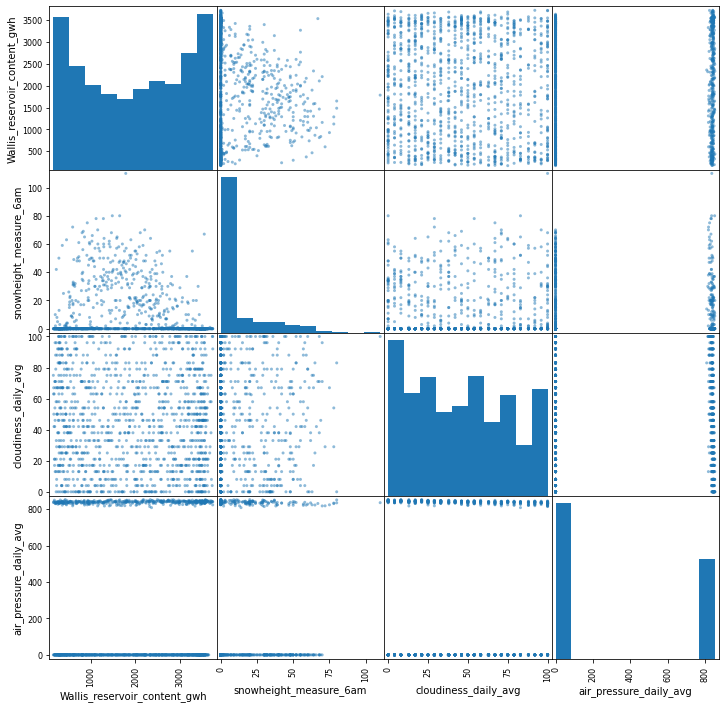

In [ ]:
column = [0,5,6,7]
pd.plotting.scatter_matrix(
    df_combined.select_dtypes(include='number').iloc[:,column],
    figsize=(12,12)
);

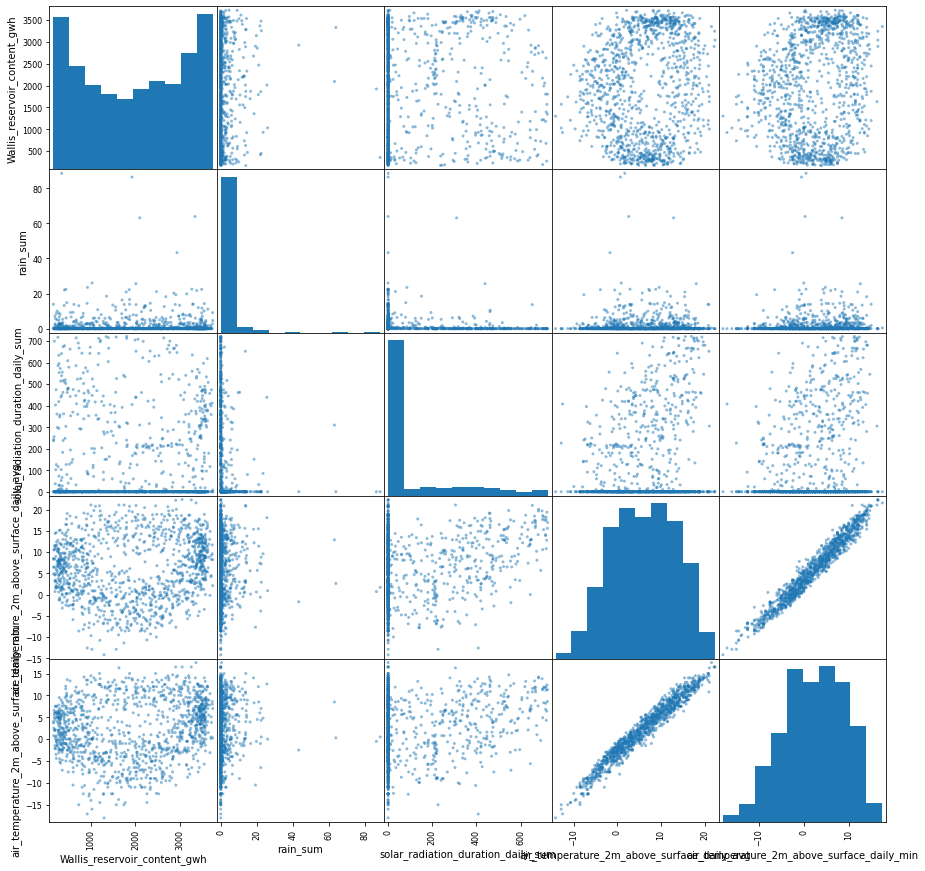

In [ ]:
column = [0,8,9,10,11]
pd.plotting.scatter_matrix(
    df_combined.select_dtypes(include='number').iloc[:,column],
    figsize=(15,15)
);

In [ ]:
df_combined_snow = df_combined[df_combined["snowheight_measure_6am"]>0]

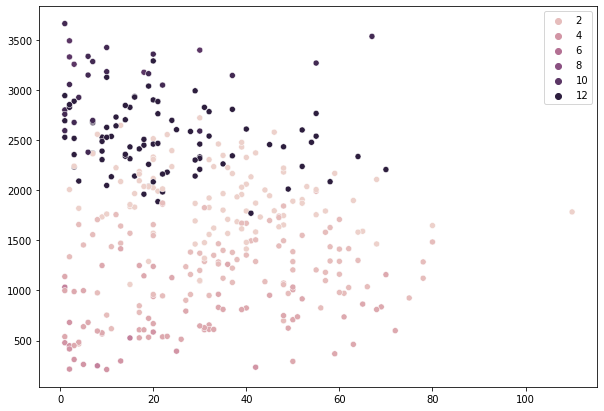

In [ ]:
snow = df_combined_snow["snowheight_measure_6am"].values.tolist()
res_content = df_combined_snow["Wallis_reservoir_content_gwh"].values.tolist()
months = df_combined_snow["Month"].values.tolist()

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7))
ax1 = sns.scatterplot(snow, res_content, hue=months)
plt.show();

**Interpretation:** No clear linear relationship can be detected for the merged dataset of weatherdata from Grächen and the water reservoir data.

In [ ]:
snow = df_combined["snowheight_measure_6am"].values.tolist()
res_content = df_combined["Wallis_reservoir_content_gwh"].values.tolist()

# Scale variables
amin, amax = min(snow), max(snow)
for i, val in enumerate(snow):
  snow[i] = (val-amin) / (amax-amin)

# Scale variables
amin, amax = min(res_content), max(res_content)
for i, val in enumerate(res_content):
  res_content[i] = (val-amin) / (amax-amin)

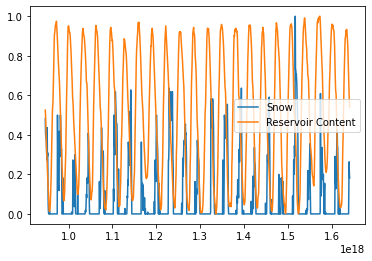

In [ ]:
index = df_combined["Date"].values.tolist()
data = {"Snow": snow, "Reservoir Content": res_content}

df_lines1= pd.DataFrame(data=data, index=index)
lines = df_lines1.plot.line()

#### EDA of Merged Data (St.Bernard & Water Reservoir)

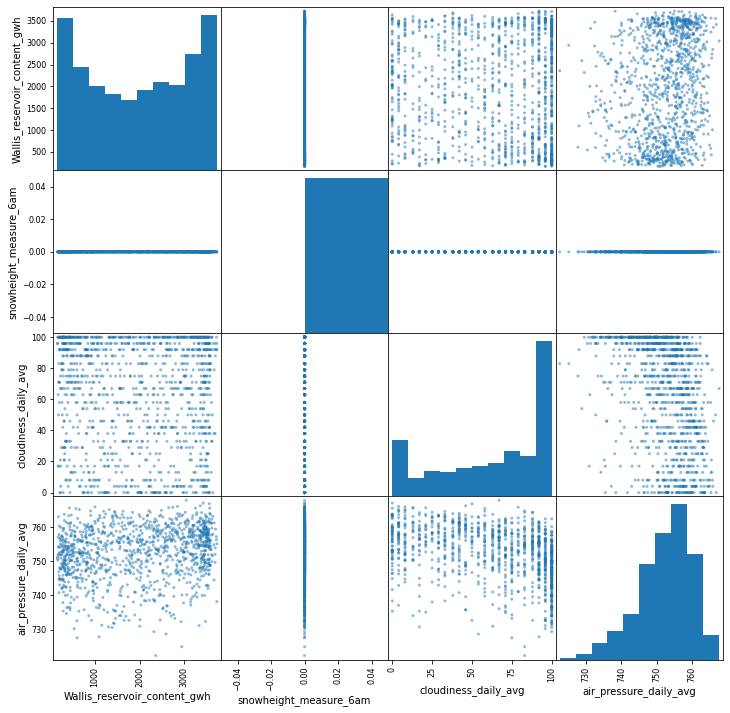

In [ ]:
column = [0,5,6,7]
pd.plotting.scatter_matrix(
    df_combined2.select_dtypes(include='number').iloc[:,column],
    figsize=(12,12)
);

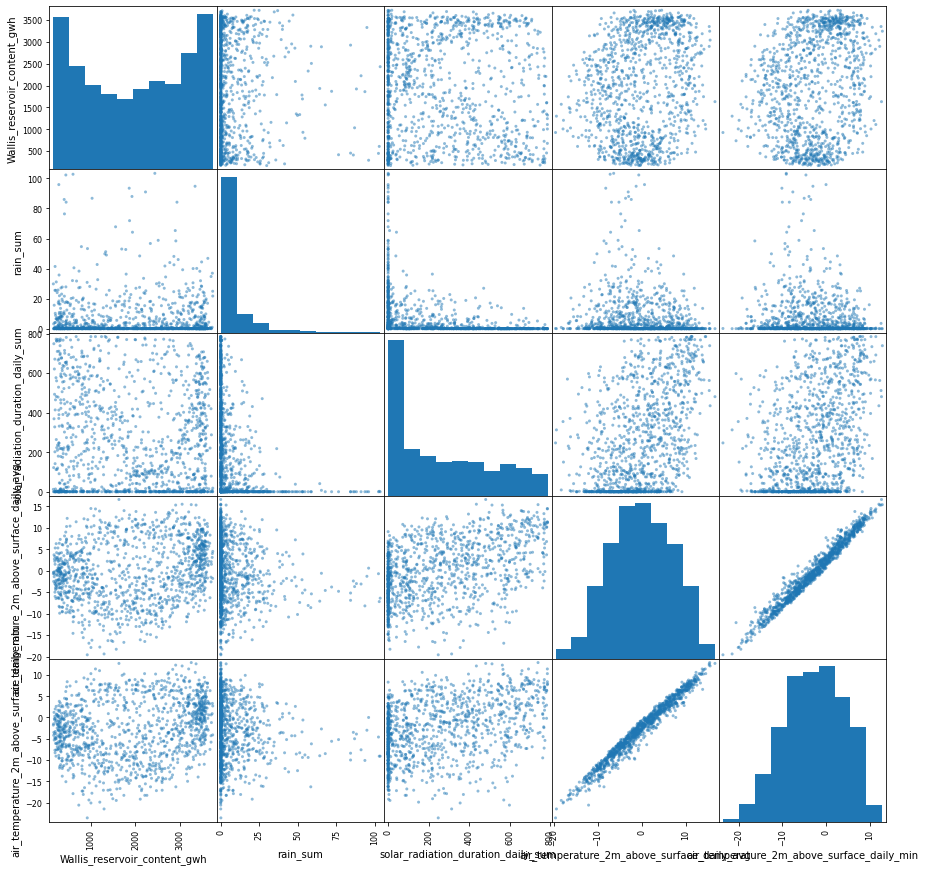

In [ ]:
column = [0,8,9,10,11]
pd.plotting.scatter_matrix(
    df_combined2.select_dtypes(include='number').iloc[:,column],
    figsize=(15,15)
);

**Interpretation:** No clear linear relationship can be detected for the merged dataset of weatherdata from Grächen and the water reservoir data. It is no dependent on the measuring stations.

## Modelling

We will use two different approaches/models to predict the water reservoir level.
1. Time Series Model (SARIMA) 
2. Random Forest

For the Time Series Model we use the DataFrame df_water_reservoir (Water Reservoir Dataset)

For Random Forest we use the Dataframe df_combined (Merged Data from Grächen & Water Reservoir). 

Note: We wont use the Elecricity Dataset for the Modelling because it was not part of our research question. We want to know if any climate variable has influence on the water reservoir level. Furthermore the granularity of the time dimension is different since the Elecriticiy Dataset reports monthly data and the Water Reservoirs is measured weekly. It is clearly possible to  sum weeks up to a month and take the average of the weekly reservoir data. However we epxect to lose too much information in the data with that approach.


#### Time Series Model

##### Inspection and Pre Processing

Lets look again on the data:

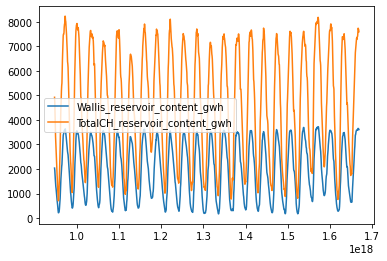

In [ ]:
# Total Vs Wallis reservoir content
Wallis_reservoir_content_gwh = df_water_reservoir["Wallis_reservoir_content_gwh"].values.tolist()
TotalCH_reservoir_content_gwh = df_water_reservoir["TotalCH_reservoir_content_gwh"].values.tolist()
data = {"Wallis_reservoir_content_gwh":Wallis_reservoir_content_gwh, "TotalCH_reservoir_content_gwh":TotalCH_reservoir_content_gwh}

index = df_water_reservoir["Date"].values.tolist()

df_lines= pd.DataFrame(data=data, index=index);
lines = df_lines.plot.line()

Its looks like that we have constant mean over time. No sudden changes are visible.  However there is a clear seaonality observable. The seasonal variations are constant with exceptions in some peaks in terms of the the strength of the amplitude deflection. All in all it speaks for an additive model and it suggests that a time series model would be a good way to predict the level in the reservoir.

There are two options to deal with seasonality: 
1. The seasonality could be removed  by backward differentation and by making an ARMA model to predict the time series. 
2. Another solution is to make a SARIMA model and to keep the seasonality.

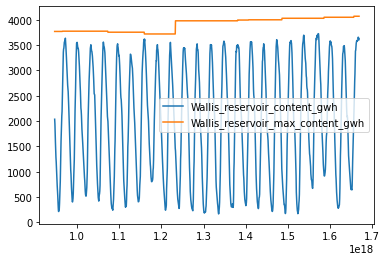

In [ ]:
# Max Reservoir capacity vs Actual content in the water reservoir
Wallis_reservoir_content_gwh = df_water_reservoir["Wallis_reservoir_content_gwh"].values.tolist()
Wallis_reservoir_max_content_gwh = df_water_reservoir["Wallis_reservoir_max_content_gwh"].values.tolist()
data = {"Wallis_reservoir_content_gwh":Wallis_reservoir_content_gwh, "Wallis_reservoir_max_content_gwh":Wallis_reservoir_max_content_gwh}

index = df_water_reservoir["Date"].values.tolist()

df_lines= pd.DataFrame(data=data, index=index);
lines = df_lines.plot.line()

There is a possbility that there a very small trend is in the data. The reason for this assumption is because the capacity of the water reservoirs are rising. This can be seen in the above plot.

In [ ]:
df_combined.dtypes

Date                                            datetime64[ns]
Wallis_reservoir_content_gwh                             int64
Wallis_reservoir_max_content_gwh                         int64
Year                                                     int64
Month                                                    int64
station/location                                        object
solar_radiation_daily_avg                              float64
snowheight_measure_6am                                 float64
cloudiness_daily_avg                                   float64
air_pressure_daily_avg                                 float64
rain_sum                                               float64
solar_radiation_duration_daily_sum                     float64
air_temperature_2m_above_surface_daily_avg             float64
air_temperature_2m_above_surface_daily_min             float64
air_temperature_2m_above_surface_daily_max             float64
relative_humidity_2m_above_surface_daily_avg           

In [ ]:
# Making a Time Series with Date as Index
index = df_combined["Date"]
ts_data = df_combined["Wallis_reservoir_content_gwh"]

ts_wallis =  pd.DataFrame(ts_data)
ts_wallis = ts_wallis.set_index(index)
print(ts_wallis)
print(type(ts_wallis))

            Wallis_reservoir_content_gwh
Date                                    
2000-01-03                          2037
2000-01-10                          1945
2000-01-17                          1733
2000-01-24                          1584
2000-01-31                          1414
...                                  ...
2021-11-29                          2622
2021-12-06                          2450
2021-12-13                          2302
2021-12-20                          2162
2021-12-27                          2084

[1148 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


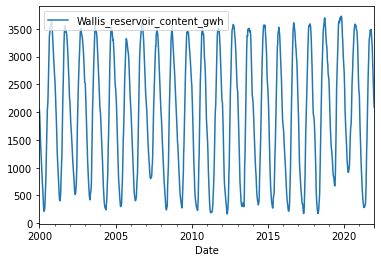

In [ ]:
# The Time Series plotted:
ts_wallis.plot(legend=True)
plt.show()

It could be possible that the time series data is skrewed in any direction. Therefore a histogram check is necessary

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9371b3ac10>]],
      dtype=object)

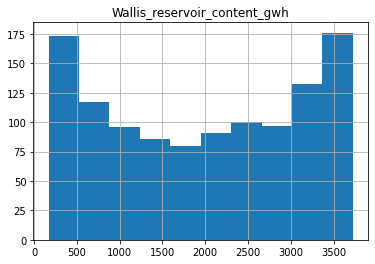

In [ ]:
# Histogram check
ts_wallis.hist()

The type of the histogram can be called u-shaped or bimodal becuase it has two two distinct peaks on the left outer and right outer side. We dont know how to deal with U shaped data and therefore we kept it like this.

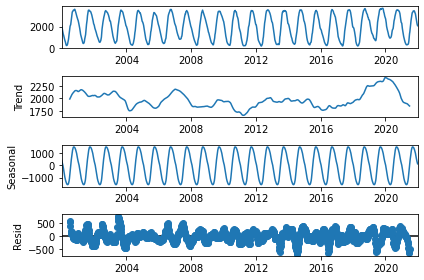

In [ ]:
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts_wallis, model='additive')
result.plot()
plt.show()

Hard to see a trend. Seasonal behaviour very strong. Residuals very randomly distributed

Next thing is to apply backward differencing and to justify the differencing order of 2 is appropiate.

In [ ]:
# Backward Differencing 
# Difference = 1
ts_wallis_lag1 = ts_wallis.diff()  

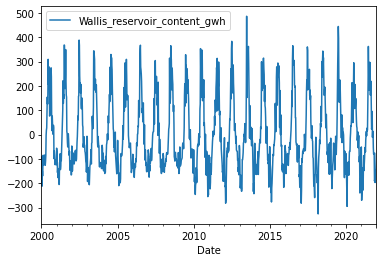

In [ ]:
# The Time Series after differentation with the 1st derivative
ts_wallis_lag1.plot(legend=True)
plt.show()

As suspected, the data are not yet stationary with a lag of 1.

In [ ]:
# Backward Differencing 
# # Difference = 2
ts_wallis_lag2 = ts_wallis.diff().diff()

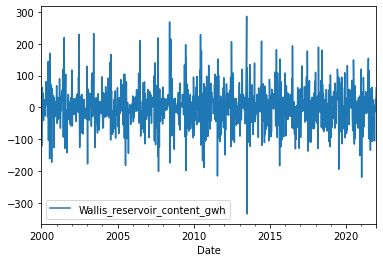

In [ ]:
# The Time Series after differentation with the 2nd derivative
ts_wallis_lag2.plot(legend=True)
plt.show()

Ok looks good! 2nd Derivative would be appropiate to make the data stationary. However in the next steps I want to devlop a SARIMA model and to keep the seasonality.

In [ ]:
# Split into test and train

#from sklearn.model_selection import train_test_split
#train, test = train_test_split(ts_wallis, test_size = 0.20, random_state = 42)

end_test = len(ts_wallis)
print(end_test)
start_test= end_test-52
print(start_test)

train = ts_wallis.iloc[:start_test] 
test = ts_wallis.iloc[start_test:end_test]

1148
1096


In [ ]:
print('Training Shape:', train.shape)
print('Test Shape:', test.shape)



Training Shape: (1096, 1)
Test Shape: (52, 1)


##### Model Identification

After the gained knowledge about the stationarity of the time series the next task is to plot ACF and PACF. With that the purpose is to know which order should be considered for the model.

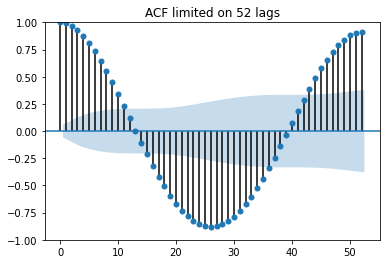

In [ ]:
# ACF
plot_acf(x= ts_wallis, lags = 52, alpha = 0.05, title = "ACF limited on 52 lags") # Plot with 95 % confidence interval
plt.show()

The ACF displays periodic structure in the data. Since the time dimension of the indexed data is one week the correlologram has to be interpreted as follows:

- Lag 1 = Week 1
- Lag 2 = Week 2
- Lag 52 or 53 = Week 52 or 53 (1 year)
...

The lowest water reservoir level is always around april-mai (the sea is empty). The highest reservoir level is arround augustseptember (the sea is full of water). It can be seen in the plot below:

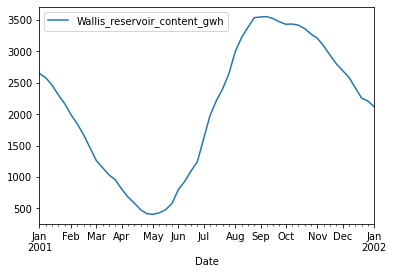

In [ ]:
ts_wallis_2ndyear = ts_wallis.iloc[52:106]
ts_wallis_2ndyear.plot(legend=True)
plt.show()

Next I expand the lags in the ACF plot:

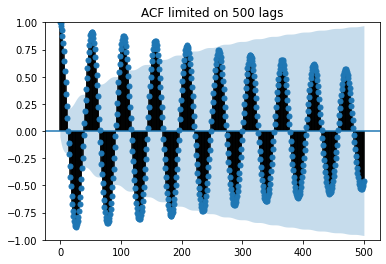

In [ ]:
# ACF
plot_acf(x= ts_wallis, lags = 500, alpha = 0.05, title = "ACF limited on 500 lags") # Plot with 95 % confidence interval
plt.show()

With higher lags the ACF shows the typical damped sinusiod curves which diverge over time in the direction to 0, the higher the lags.

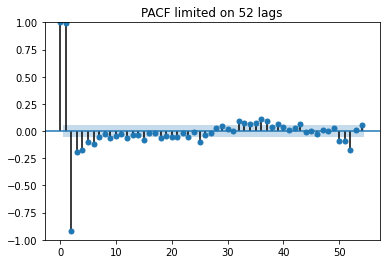

In [ ]:
# PACF
plot_pacf(x = ts_wallis, lags = 54, alpha = 0.05, title = "PACF limited on 52 lags", method="ywm")
plt.show()

The PACF shows a clear cut off at lag of p=2. Another cut off which is that dominant can not be further observed in the plot. The cut-off at p combined with a damped sinusoid behaviour in the ACF suggests that the MA part does not play a role and we can set q = 0. A seasonal component could be present at lag 52.

In [ ]:
print(ts_wallis.iloc[3]) #lag of 2 (+1 because python)


Wallis_reservoir_content_gwh    1584
Name: 2000-01-24 00:00:00, dtype: int64


The Lag of 2 is the 3rd week in january and the first week in june. 

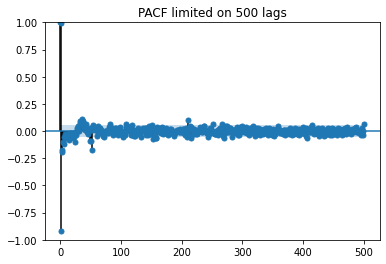

In [ ]:
# PACF
plot_pacf(x = ts_wallis, lags = 500, alpha = 0.05, title = "PACF limited on 500 lags", method="ywm")
plt.show()

Based on the (P)ACF and seasonal behaviour I would go for in a first step for
SARIMA model with:(2,1,0)(0,1,0,52). The seasonal component  could be removed with a backward differentation with the 2nd Derivativeas shown in in the Subchapter "Inspection and Pre Processing".

However: By only considering the PACF plot the peak at lag 52 in the PACF was not that clear as expected. Therefore I think it could be also a simple AR(2) model. Both options will be trained.

##### Modelling

###### Own Model SARIMA

SARIMA model with:(2,1,0)(0,1,0,52)

In [ ]:
# Define the first model -- very slow code with SARIMAX

#order = (2,1,0)
#seasonal_order = (0,1,0,52) 
#model1 = SARIMAX (train, order=order, seasonal_order =seasonal_order)
#start = time()
#model1_fit = model1.fit()
#end = time()
#print("Model fitting is finished. Fitting Time:", end - start)
# Dont run this it takes more than 1 hour ;)

In [ ]:
# Define the first model with seasonal component-- better with arima.ARIMA package
order = (2,1,0)
seasonal_order = (0,1,0,52) 

start = time()
model1 = sm.tsa.arima.ARIMA(train, order=order, seasonal_order=seasonal_order)
model1_fit = model1.fit(method='innovations_mle', low_memory=True) #, cov_type='none'
end = time()
print("Model fitting is finished. Fitting Time:", end - start)

Model fitting is finished. Fitting Time: 0.906827449798584


In [ ]:
# Summary of the Model
print(model1_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:     Wallis_reservoir_content_gwh   No. Observations:                 1096
Model:             ARIMA(2, 1, 0)x(0, 1, 0, 52)   Log Likelihood               -5898.550
Date:                          Thu, 22 Dec 2022   AIC                          11803.099
Time:                                  15:16:14   BIC                          11817.949
Sample:                              01-03-2000   HQIC                         11808.732
                                   - 12-28-2020                                         
Covariance Type:                         approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4175      0.031     13.502      0.000       0.357       0.478
ar.L2          0.0471      0.031      1.524      0.

In [ ]:
print(model1_fit.model_orders)

{'trend': 0, 'exog': 0, 'ar': 2, 'ma': 0, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 2, 'reduced_ma': 0, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}


###### Own Model AR

The seasonal component at lag 52 was not that obvious in the data. Therefore it could be also an (2,0,0) (0,0,0,0) model --> AR(2)

In [ ]:
# Define the second model without seasonal component -- better with arima.ARIMA package
order = (2,0,0)
seasonal_order = (0,0,0,0) 

start = time()
model2 = sm.tsa.arima.ARIMA(train, order=order, seasonal_order=seasonal_order)
model2_fit = model2.fit(method='innovations_mle', low_memory=True) #, cov_type='none'
end = time()
print("Model fitting is finished. Fitting Time:", end - start)

Model fitting is finished. Fitting Time: 0.2576007843017578


In [ ]:
# Summary of the Model
print(model2_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:     Wallis_reservoir_content_gwh   No. Observations:                 1096
Model:                           ARIMA(2, 0, 0)   Log Likelihood               -6029.240
Date:                          Thu, 22 Dec 2022   AIC                          12066.479
Time:                                  15:16:14   BIC                          12086.477
Sample:                              01-03-2000   HQIC                         12074.046
                                   - 12-28-2020                                         
Covariance Type:                         approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1979.6047    106.181     18.644      0.000    1771.494    2187.715
ar.L1          1.9007      0.012    161.039      0.

###### Auto ARIMA

In [ ]:
# Auto ARIMA
model_fit_auto_arima = auto_arima (y = train)

In [ ]:
# Summary of the Model
print(model_fit_auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1096
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -5965.067
Date:                Thu, 22 Dec 2022   AIC                          11942.133
Time:                        15:16:40   BIC                          11972.130
Sample:                    01-03-2000   HQIC                         11953.483
                         - 12-28-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.9987      1.320      9.849      0.000      10.412      15.585
ar.L1          2.5237      0.033     75.988      0.000       2.459       2.589
ar.L2         -2.0738      0.065    -32.038      0.0

In [ ]:
print(model_fit_auto_arima.order)
print(model_fit_auto_arima.seasonal_order)

(3, 0, 1)
(0, 0, 0, 0)


According to Auto ARIMA the Model is an ARIMA with (p,d,q) = (3,0,1) and no seaonsal component.

##### Model Diagnostics / Evaluation

###### Own model SARIMA

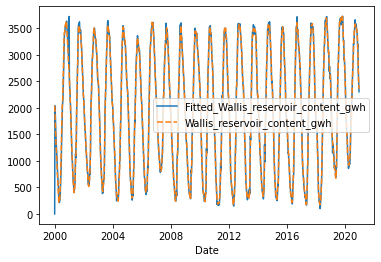

In [ ]:
# Fitted Values
model1_fitted = model1_fit.fittedvalues
#print(auto_arima_fitted)
ts_fitted = pd.DataFrame(data= model1_fitted, columns =["Fitted_Wallis_reservoir_content_gwh"])

# Merge with Actual Values in a dataframe
df = pd.merge(ts_fitted,ts_wallis, left_index = True, right_index = True)

# Lineplot
sns.lineplot(data=df)
#lines = df.plot.line()

**Interpretation**: The model can fit the actual values well.

In [ ]:
# Get the Residuals
model1_resid = model1_fit.resid
print(model1_resid)

Date
2000-01-03    2037.000000
2000-01-10     -94.639032
2000-01-17    -213.141422
2000-01-24    -149.024867
2000-01-31    -169.620696
                 ...     
2020-11-30    -209.447006
2020-12-07      27.660818
2020-12-14     -38.191007
2020-12-21     -38.811798
2020-12-28      54.942547
Length: 1096, dtype: float64


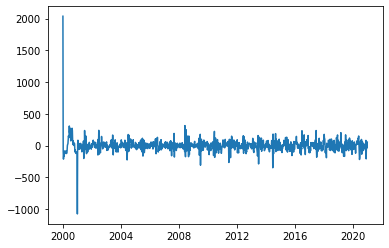

In [ ]:
# Visualize the Residuals
plt.plot(model1_resid)

**Interpretation**: The residuals have strong fluctuations in the beginning, which is absolutely logical for the year 2000. It is the first year in the dataset and there is no information about the lag 52 in that year based on previous years.

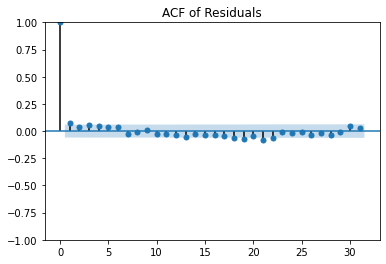

In [ ]:
# ACF of the residuals
plot_acf(x= model1_resid, alpha = 0.05, title = "ACF of Residuals") # Plot with 95 % confidence interval
plt.show()

ACF plot shows no siginicant lags outside the confidence band. Nice!

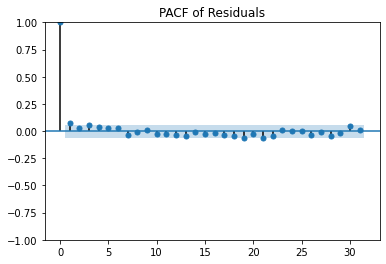

In [ ]:
# PACF of the residuals
plot_pacf(x= model1_resid, alpha = 0.05, title = "PACF of Residuals") # Plot with 95 % confidence interval
plt.show()

PACF plot shows no siginicant lags outside the confidence band. Very Nice!

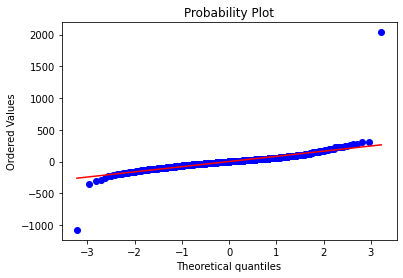

In [ ]:
## QQ Plot of the Residuals
import numpy as np 
import pylab 
import scipy.stats as stats
stats.probplot(model1_resid, dist="norm", plot=pylab)
pylab.show()


**Interpretation**: Theoretical and practical quantiles are fitting quite well the line. There are two strong outliers which could be considered as the data at the very begin where no seasonal information was given.

###### Own model AR

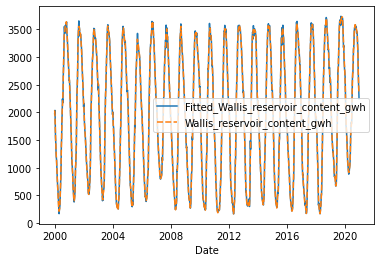

In [ ]:
# Fitted Values
model2_fitted = model2_fit.fittedvalues
#print(auto_arima_fitted)
ts_fitted = pd.DataFrame(data= model2_fitted, columns =["Fitted_Wallis_reservoir_content_gwh"])

# Merge with Actual Values in a dataframe
df = pd.merge(ts_fitted,ts_wallis, left_index = True, right_index = True)

# Lineplot
sns.lineplot(data=df)
#lines = df.plot.line()

**Interpretation**: The model can fit the actual values well.

In [ ]:
# Get the Residuals
model2_resid = model2_fit.resid
print(model2_resid)

Date
2000-01-03     57.395251
2000-01-10    -91.498822
2000-01-17   -128.173487
2000-01-24     41.371595
2000-01-31    -39.922860
                 ...    
2020-11-30   -137.444172
2020-12-07     34.073219
2020-12-14      1.728469
2020-12-21     17.826014
2020-12-28    112.893743
Length: 1096, dtype: float64


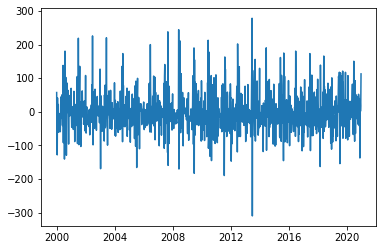

In [ ]:
# Visualize the Residuals
plt.plot(model2_resid)

**Interpretation**: The residuals have nicer look. Only around the year 2013 there is very strong peak in the data which could be a substantial problem.

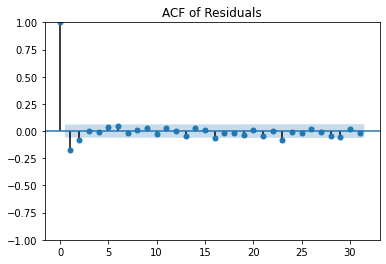

In [ ]:
# ACF of the residuals
plot_acf(x= model2_resid, alpha = 0.05, title = "ACF of Residuals") # Plot with 95 % confidence interval
plt.show()

**Interpretation**: With an AR(2) model the residuals still show autocorrelated lags which are considered as significant. Here we can see at q=1, q=2 and q=23 data points which are outside of the confidence band.

The correlated values are an indication that the AR(2) is not appropiate.

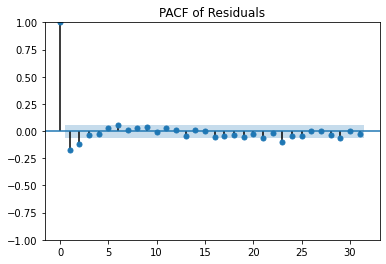

In [ ]:
# PACF of the residuals
plot_pacf(x= model2_resid, alpha = 0.05, title = "PACF of Residuals") # Plot with 95 % confidence interval
plt.show()

The same observation also applies to the PACF.

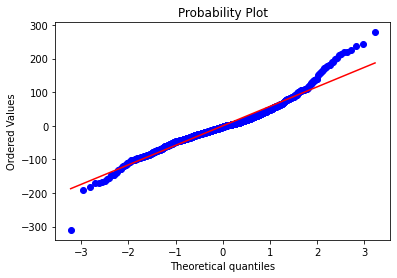

In [ ]:
## QQ Plot of the Residuals
import numpy as np 
import pylab 
import scipy.stats as stats
stats.probplot(model2_resid, dist="norm", plot=pylab)
pylab.show()


QQ Plot is not optimal and seems that practical quantiles in the upper right part are substantially lower than the theoretical quantiles.  

###### AutoARIMA

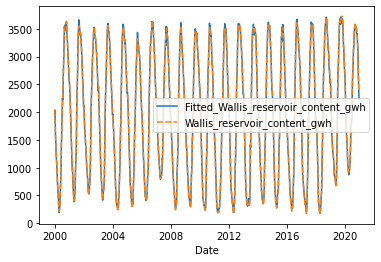

In [ ]:
# Fitted Values
auto_arima_fitted = model_fit_auto_arima.fittedvalues()
#print(auto_arima_fitted)
ts_fitted = pd.DataFrame(data= auto_arima_fitted, columns =["Fitted_Wallis_reservoir_content_gwh"])

# Merge with Actual Values in a dataframe
df = pd.merge(ts_fitted,ts_wallis, left_index = True, right_index = True)

# Lineplot
sns.lineplot(data=df)
#lines = df.plot.line()


**Interpretation**: Fitted Values vs actual values looks good. 

In [ ]:
# Get the Residuals
auto_arima_resid = model_fit_auto_arima.resid()
print(auto_arima_resid)

Date
2000-01-03     54.579985
2000-01-10    -91.503894
2000-01-17   -129.573253
2000-01-24     20.467292
2000-01-31    -42.996539
                 ...    
2020-11-30   -111.472799
2020-12-07     22.808400
2020-12-14      7.845034
2020-12-21     29.628045
2020-12-28    133.955592
Length: 1096, dtype: float64


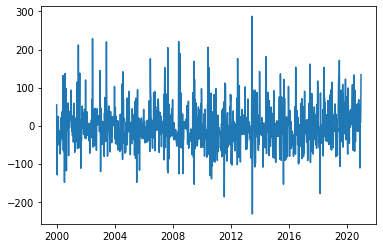

In [ ]:
# Visualize the Residuals
plt.plot(auto_arima_resid)

**Interpretation**: One strong peak at around 2013. Rest of residuals looks good.

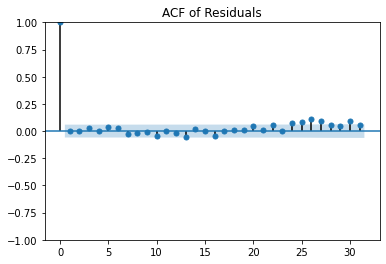

In [ ]:
# ACF of the residuals
plot_acf(x= auto_arima_resid, alpha = 0.05, title = "ACF of Residuals") # Plot with 95 % confidence interval
plt.show()

**Interpretation**: Lags at 24,25,26, and 30 are outside of the confidence band. It means that these lags might play a significant role on the residuals. 

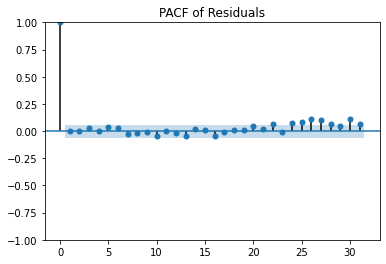

In [ ]:
# PACF of the residuals
plot_pacf(x= auto_arima_resid, alpha = 0.05, title = "PACF of Residuals") # Plot with 95 % confidence interval
plt.show()

**Interpretation**: Lags at 24,25,26, and 30 are outside of the confidence band. It means that these lags plays a small significant role on the residuals. 

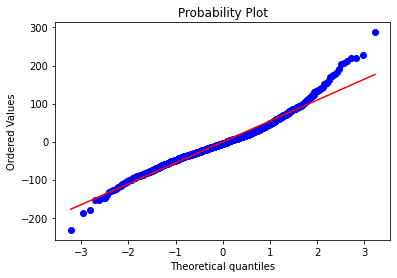

In [ ]:
## QQ Plot of the Residuals

import numpy as np 
import pylab 
import scipy.stats as stats
stats.probplot(auto_arima_resid, dist="norm", plot=pylab)
pylab.show()

**Interpretation**: QQ Plot doesnt look that good. Both ends seems to "go away" from the line. Sorry for the bad wording.

###### Comparison of Auto ARIMA with Own models and Decision

In [ ]:
# AICs
aic_model1 = model1_fit.aic
aic_model2 = model2_fit.aic
aic_auto_arima = model_fit_auto_arima.aic()
print("Own model 1:", aic_model1, "Own model 2:", aic_model2, "Auto Arima:", aic_auto_arima)

Own model 1: 11803.099440903134 Own model 2: 12066.479291815436 Auto Arima: 11942.133399728827


The lowest AIC indicates the most appropiate model. In this case it is the Own Model 1. For a final decision on which model is most suitable, the values are still predicted and compared with the test values.

##### Forecasting

After evaluating the model a forecast can now be executed.

In [ ]:
# Forecast
#print(test.iloc[0]) # 2021-01-04 00:00:00, # Test Start
#print(test.iloc[51]) # 2021-12-27 00:00:00 # Test End

predictions_model1 = model1_fit.forecast(52)
predictions_model2 = model2_fit.forecast(52)
predictions_model_auto_arima = model_fit_auto_arima.predict(52)


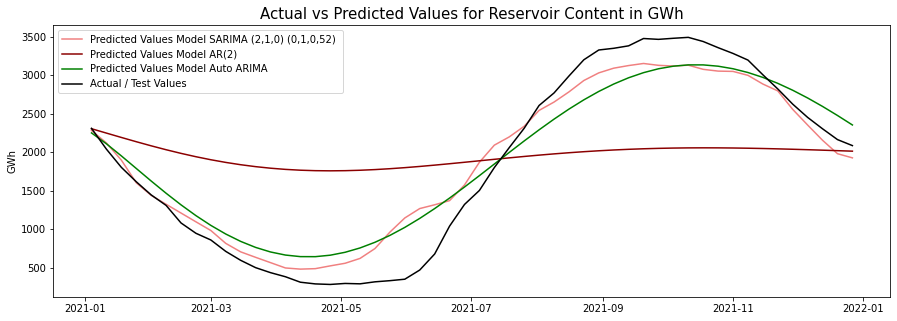

In [ ]:
# Lets try to make a graph indicating the difference in actual and predicted values for the test-data

# Define the values
x_labels = list(range(1,91))
values_pred = predictions_model1
values_pred2 = predictions_model2
values_pred_auto = predictions_model_auto_arima
values_actual = test

# Define the plot
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(15,5))
ax1.plot(values_pred, color = "#F08080", label= "Predicted Values Model SARIMA (2,1,0) (0,1,0,52) ") # different types of red
ax1.plot(values_pred2, color = "#8B0000", label = "Predicted Values Model AR(2)") # different types of red
ax1.plot(values_pred_auto, color = "green", label = "Predicted Values Model Auto ARIMA")
ax1.plot(values_actual, color = "black", label ="Actual / Test Values")
ax1.legend()
ax1.set_title("Actual vs Predicted Values for Reservoir Content in GWh",
              size = 15)
ax1.set_ylabel("GWh")
plt.show();

**Decision**: Okay we dont have to go further with AR(2) model. It is now clear that this model is not appropiate since it can not handle the seasonality.

Together with plot from above and the lower AIC the SARIMA Model  (2,1,0) (0,1,0,52) seems to the better model. Lets check the Mean Absolute Error and the Accuracy on both predictions to have clear number.

In [ ]:
# Change to Data Frame
predictions_model1 = pd.DataFrame(predictions_model1)
predictions_model1 = predictions_model1.rename(columns= {"predicted_mean": "predicted"})
predictions_model_auto_arima = pd.DataFrame(predictions_model_auto_arima)
predictions_model_auto_arima = predictions_model_auto_arima.rename(columns={0:"predicted"})

# Calculate the absolute errors
errors = abs(predictions_model1["predicted"]- test["Wallis_reservoir_content_gwh"])
errors2 = abs(predictions_model_auto_arima["predicted"]- test["Wallis_reservoir_content_gwh"])

# Calculate Root Mean Squared Errors
rmse_1 = sqrt(mean_squared_error(predictions_model1["predicted"], test["Wallis_reservoir_content_gwh"]))
rmse_2 = sqrt(mean_squared_error(predictions_model_auto_arima["predicted"], test["Wallis_reservoir_content_gwh"]))

# Print out the mean absolute error (mae)
print('Mean Absolute Error Own Model:', round(np.mean(errors), 2), 'degrees.')
print('Mean Absolute Error Auto Arima Model:', round(np.mean(errors2), 2), 'degrees.')

print('Mean Squared Error Own Model:', round(rmse_1, 2))
print('Mean Squared Error Auto Arima Model:', round(rmse_2, 2))

Mean Absolute Error Own Model: 228.4 degrees.
Mean Absolute Error Auto Arima Model: 300.58 degrees.
Mean Squared Error Own Model: 290.08
Mean Squared Error Auto Arima Model: 339.23


Mean Absolut Error is lower for the SARIMA model.

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test["Wallis_reservoir_content_gwh"])
mape2 = 100 * (errors2 / test["Wallis_reservoir_content_gwh"])

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy of SARIMA Model:', round(accuracy, 2), '%.')

accuracy2 = 100 - np.mean(mape2)
print('Accuracy of Auto Arima Model:', round(accuracy2, 2), '%.')

Accuracy of SARIMA Model: 68.15 %.
Accuracy of Auto Arima Model: 59.44 %.


**Final Decision**: Accuarcy is better for the SARIMA Model. Together with the arguments we already evaluated this leads to the SARIMA model becoming the final model.

The human eye could outperform the Auto ARIMA from the computer!

#### Random Forest (Model 1: with Dummy Variables for Year and Month)

**Clean and One-Hot-Encode Dataframe**

In [ ]:
# Create new variable features and subset the dataframe, additionaly remove some columns which are not needed
features = df_combined
features = features[features["Date"]>"2013-06-01"]
features.drop(["station/location", "Wallis_reservoir_max_content_gwh"], inplace=True, axis=1)

In [ ]:
# Create dummies for the months
month_dummies = pd.get_dummies(features.Month, prefix='Month')

In [ ]:
# Create dummies for the years
year_dummies = pd.get_dummies(features.Year, prefix='Year')

In [ ]:
# Drop the initial columns for months and years
features.drop(["Month", "Year"], inplace=True, axis=1)

In [ ]:
# Concat the dataframe and add the dummy-variables
features = pd.concat([features, year_dummies.reindex(features.index)], axis=1)
features = pd.concat([features, month_dummies.reindex(features.index)], axis=1)

In [ ]:
features.dtypes

Date                                            datetime64[ns]
Wallis_reservoir_content_gwh                             int64
solar_radiation_daily_avg                              float64
snowheight_measure_6am                                 float64
cloudiness_daily_avg                                   float64
air_pressure_daily_avg                                 float64
rain_sum                                               float64
solar_radiation_duration_daily_sum                     float64
air_temperature_2m_above_surface_daily_avg             float64
air_temperature_2m_above_surface_daily_min             float64
air_temperature_2m_above_surface_daily_max             float64
relative_humidity_2m_above_surface_daily_avg           float64
Year_2013                                                uint8
Year_2014                                                uint8
Year_2015                                                uint8
Year_2016                                              

**Train and Test Split**

In [ ]:
# Split the dependant and independant variables

# 1). Independant variable (label)
labels = np.array(features["Wallis_reservoir_content_gwh"])
# 2). Date Values
dates = np.array(features["Date"])
# 3). Remove the label column from the features dataframe
features = features.drop(["Wallis_reservoir_content_gwh", "Date"], axis = 1)

In [ ]:
# Save the feature names for later use
feature_list = list(features.columns)
# Convert features to numpy-array
features = np.array(features)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (358, 31)
Training Labels Shape: (358,)
Testing Features Shape: (90, 31)
Testing Labels Shape: (90,)


The split seems to be done correctly the same number of rows was obtained for test and training, comparing features and labels.

**Train Model**

In [ ]:
# Import the model we are using, in this case Random-Forest-Regressor
from sklearn.ensemble import RandomForestRegressor
# Train model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

**Predicting the Water Reservoir Level**

When performing regression, we need to make sure to use the absolute error because we expect some of our answers to be low and some to be high. We are interested in how far away our average prediction is from the actual value so we take the absolute value.

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Calculate Root Mean Squared Error
rmse_rf = sqrt(mean_squared_error(predictions, test_labels))
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Mean Squared Error:', round(rmse_rf, 2))

Mean Absolute Error: 247.72 degrees.
Mean Squared Error: 312.97


Our mean absolute error is 247.72 degrees. By now we cannot compare this measure to anything else. We did not establish a baseline-model by for example taking the average of the water-reservoir level over time and compare it to these values.

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 81.64 %.


When computing the accuracy of our model we obtain 81.64%, which is note the badest results to get. Our model has learned how to predict the water reservoir levell for the next week in the Canton of Wallis with 81.6% accuracy.

**Feature Importance**

In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables. The importances returned in Skicit-learn represent how much including a particular variable improves the prediction.

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Month_5              Importance: 0.11
Variable: Month_4              Importance: 0.1
Variable: solar_radiation_daily_avg Importance: 0.09
Variable: Month_9              Importance: 0.09
Variable: Month_10             Importance: 0.09
Variable: Month_7              Importance: 0.08
Variable: Month_3              Importance: 0.07
Variable: Month_6              Importance: 0.07
Variable: Month_8              Importance: 0.07
Variable: Month_2              Importance: 0.05
Variable: Month_11             Importance: 0.03
Variable: snowheight_measure_6am Importance: 0.02
Variable: Month_1              Importance: 0.02
Variable: Month_12             Importance: 0.02
Variable: cloudiness_daily_avg Importance: 0.01
Variable: air_pressure_daily_avg Importance: 0.01
Variable: rain_sum             Importance: 0.01
Variable: solar_radiation_duration_daily_sum Importance: 0.01
Variable: air_temperature_2m_above_surface_daily_avg Importance: 0.01
Variable: air_temperature_2m_above_surface_d

In terms of variable importance it turns out the our computed random forest considers The months included in the dataset as most useful. This indicates that the predictions is heavely time-related. Furthermore, of importance is the "solar radiation daily average", which is rather suprising, since the sun is not particulary an indiactor of season. We would have expected the average air temperature to play a more important role.  

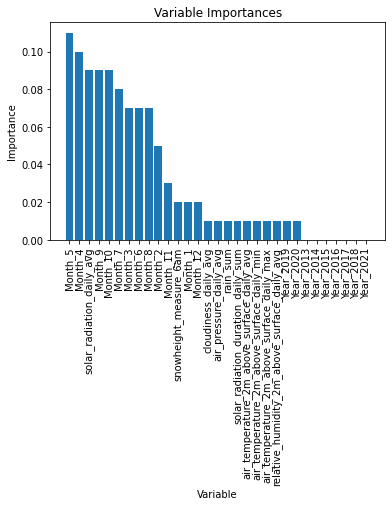

In [ ]:
# Create two lists for variable and value
x_labels = []
x_values = []

for text,value in feature_importances:
  x_labels.append(text)
  x_values.append(value)


# Make a bar chart
plt.bar(x_labels, x_values, orientation = 'vertical')
plt.xticks(rotation=90)
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Based on the variable importance another model could be computed by additionally taking into account the week of the year or the weekday, since this might improve the model. Furthermore, some variables can be left out. It can be seen that the years do not play an important role in the prediction of the water reservoir levels and can potentially be left out. 

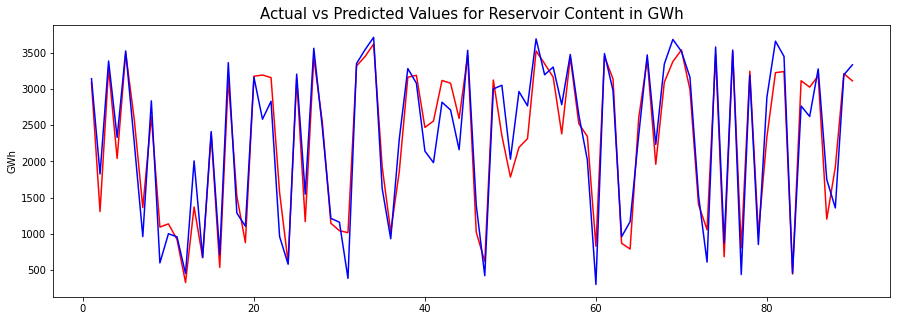

In [ ]:
# Lets try to make a graph indicating the difference in actual and predicted values for the test-data

# Define the values
x_labels = list(range(1,91))
values_pred = predictions
values_actual = test_labels
# Define the plot
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(15,5))
ax1.plot(x_labels, values_pred, color = "red")
ax1.plot(x_labels, values_actual, color = "blue")
ax1.set_title("Actual vs Predicted Values for Reservoir Content in GWh",
              size = 15)
ax1.set_ylabel("GWh")
plt.show();

The red line is representing the predicted values, whereas the the black line is representing the test-values. It seems that the prediction is doing a good job overall. There are sometimes values, where the model is over-and under forecasting. 

#### Random Forest (Model 2: with Sliding Windows)

Now the second Random Forecast model is getting computed. We are performing roughly the same data transformations as in the first model. A subset of the dataframe is getting made by taking only the values from June 2013 onwards. Columns like "station" and also "Year" and "Month" are getting excluded, despite the fact, that they were important for the first model.

The goal is to construct a time series datasets that can be transformed into a supervised learning problem using a sliding-window representation of the target variable. The sliding windows are choosen as T-1, T-3, T-6 and T-12. These sliding windows are choosen, since the data follows a seasonal pattern which might be predicted using the previous years value.

In [ ]:
# Subset the dataframe, additionaly remove some columns which are not needed
features_model2 = df_combined
features_model2 = features_model2[features_model2["Date"]>"2013-06-01"]
features_model2.drop(["station/location", "Wallis_reservoir_max_content_gwh", "Year", "Month"], inplace=True, axis=1)
features_model2.set_index("Date", inplace=True)

In [ ]:
features_model2.head(5)

Wallis_reservoir_content_gwh  solar_radiation_daily_avg  \
Date                                                                  
2013-06-03                           297                      361.0   
2013-06-10                           341                      193.0   
2013-06-17                           541                      339.0   
2013-06-24                          1027                      216.0   
2013-07-01                          1179                      371.0   

            snowheight_measure_6am  cloudiness_daily_avg  \
Date                                                       
2013-06-03                     0.0                  25.0   
2013-06-10                     0.0                  75.0   
2013-06-17                     0.0                  17.0   
2013-06-24                     0.0                  75.0   
2013-07-01                     0.0                  13.0   

            air_pressure_daily_avg  rain_sum  \
Date                                           
2013-06-03                   839.6       0.0   
2013-06-10                   835.2       0.0   
2013-06-17                   843.3       0.0   
2013-06-24                   841.4       0.0   
2013-07-01                   842.8       0.0   

            solar_radiation_duration_daily_sum  \
Date                                             
2013-06-03                               554.0   
2013-06-10                               103.0   
2013-06-17                               663.0   
2013-06-24                               201.0   
2013-07-01                               713.0   

            air_temperature_2m_above_surface_daily_avg  \
Date                                                     
2013-06-03                                         7.9   
2013-06-10                                         8.2   
2013-06-17                                        18.5   
2013-06-24                                         7.9   
2013-07-01                                        13.9   

            air_temperature_2m_above_surface_daily_min  \
Date                                                     
2013-06-03                                         4.0   
2013-06-10                                         5.1   
2013-06-17                                        13.3   
2013-06-24                                         3.8   
2013-07-01                                         6.8   

            air_temperature_2m_above_surface_daily_max  \
Date                                                     
2013-06-03                                        14.0   
2013-06-10                                        13.3   
2013-06-17                                        24.1   
2013-06-24                                        12.6   
2013-07-01                                        20.9   

            relative_humidity_2m_above_surface_daily_avg  
Date                                                      
2013-06-03                                          65.4  
2013-06-10                                          81.6  
2013-06-17                                          52.2  
2013-06-24                                          57.9  
2013-07-01                                          56.9

In [ ]:
# Create sliding windows (T-1, T-3, T-6, T-12) --> 
features_model2["Wallis_reservoir_content_gwh_T-1"] = features_model2["Wallis_reservoir_content_gwh"].shift(+1)
features_model2["Wallis_reservoir_content_gwh_T-3"] = features_model2["Wallis_reservoir_content_gwh"].shift(+3)
features_model2["Wallis_reservoir_content_gwh_T-6"] = features_model2["Wallis_reservoir_content_gwh"].shift(+6)
features_model2["Wallis_reservoir_content_gwh_T-12"] = features_model2["Wallis_reservoir_content_gwh"].shift(+12)
features_model2.dropna(inplace = True)

In [ ]:
features_model2.head(5)

Wallis_reservoir_content_gwh  solar_radiation_daily_avg  \
Date                                                                  
2013-08-26                          3379                      171.0   
2013-09-02                          3364                      238.0   
2013-09-09                          3483                      233.0   
2013-09-16                          3480                       50.0   
2013-09-23                          3497                      203.0   

            snowheight_measure_6am  cloudiness_daily_avg  \
Date                                                       
2013-08-26                     0.0                  71.0   
2013-09-02                     0.0                  42.0   
2013-09-09                     0.0                  46.0   
2013-09-16                     0.0                  96.0   
2013-09-23                     0.0                   0.0   

            air_pressure_daily_avg  rain_sum  \
Date                                           
2013-08-26                   836.0       0.7   
2013-09-02                   848.2       0.0   
2013-09-09                   842.5       0.1   
2013-09-16                   832.5       9.0   
2013-09-23                   846.1       0.0   

            solar_radiation_duration_daily_sum  \
Date                                             
2013-08-26                               199.0   
2013-09-02                               536.0   
2013-09-09                               468.0   
2013-09-16                                 2.0   
2013-09-23                               474.0   

            air_temperature_2m_above_surface_daily_avg  \
Date                                                     
2013-08-26                                         9.3   
2013-09-02                                        12.2   
2013-09-09                                         9.3   
2013-09-16                                         6.5   
2013-09-23                                        11.4   

            air_temperature_2m_above_surface_daily_min  \
Date                                                     
2013-08-26                                         5.7   
2013-09-02                                         7.4   
2013-09-09                                         6.1   
2013-09-16                                         5.6   
2013-09-23                                         6.9   

            air_temperature_2m_above_surface_daily_max  \
Date                                                     
2013-08-26                                        14.9   
2013-09-02                                        18.5   
2013-09-09                                        14.8   
2013-09-16                                         7.7   
2013-09-23                                        17.2   

            relative_humidity_2m_above_surface_daily_avg  \
Date                                                       
2013-08-26                                          80.0   
2013-09-02                                          67.0   
2013-09-09                                          76.4   
2013-09-16                                          95.7   
2013-09-23                                          51.4   

            Wallis_reservoir_content_gwh_T-1  \
Date                                           
2013-08-26                            3306.0   
2013-09-02                            3379.0   
2013-09-09                            3364.0   
2013-09-16                            3483.0   
2013-09-23                            3480.0   

            Wallis_reservoir_content_gwh_T-3  \
Date                                           
2013-08-26                            2832.0   
2013-09-02                            3124.0   
2013-09-09                            3306.0   
2013-09-16                            3379.0   
2013-09-23                            3364.0   

            Wallis_reservoir_content_gwh_T-6  \
Date                                     

In [ ]:
features_model2.shape

(436, 15)

In [ ]:
# Split the dependant and independant variables

# 1). Independant variable (label)
labels = np.array(features_model2["Wallis_reservoir_content_gwh"])
# 2). Remove the label column from the features dataframe
features_2 = features_model2.drop(["Wallis_reservoir_content_gwh"], axis = 1)

In [ ]:
# Save the feature names for later use
feature_list = list(features_2.columns)
# Convert features to numpy-array
features_2 = np.array(features_2)

In [ ]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features_2, labels, test_size = 0.20, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (348, 14)
Training Labels Shape: (348,)
Testing Features Shape: (88, 14)
Testing Labels Shape: (88,)


In [ ]:
# Train model with 1000 decision trees
rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf2.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf2.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Calculate Root Mean Squared Error
rmse_rf2 = sqrt(mean_squared_error(predictions, test_labels))
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Mean Squared Error:', round(rmse_rf2, 2))

Mean Absolute Error: 73.46 degrees.
Mean Squared Error: 92.79


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 94.17 %.


In [ ]:
# Get numerical feature importances
importances = list(rf2.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Wallis_reservoir_content_gwh_T-1 Importance: 0.9873
Variable: Wallis_reservoir_content_gwh_T-12 Importance: 0.003
Variable: air_temperature_2m_above_surface_daily_min Importance: 0.0022
Variable: solar_radiation_daily_avg Importance: 0.0013
Variable: air_temperature_2m_above_surface_daily_max Importance: 0.0012
Variable: Wallis_reservoir_content_gwh_T-6 Importance: 0.0011
Variable: air_temperature_2m_above_surface_daily_avg Importance: 0.001
Variable: Wallis_reservoir_content_gwh_T-3 Importance: 0.0009
Variable: snowheight_measure_6am Importance: 0.0004
Variable: solar_radiation_duration_daily_sum Importance: 0.0004
Variable: relative_humidity_2m_above_surface_daily_avg Importance: 0.0004
Variable: cloudiness_daily_avg Importance: 0.0003
Variable: air_pressure_daily_avg Importance: 0.0003
Variable: rain_sum             Importance: 0.0001


The findings for the variable importance are very interesting. We would have assumed, that the sliding windows pay an important role in the importance of the variables compared to the weather data. This was also indicated in the first computed random forest model. But it seems that to predict this months reservoir content level, our model only need to know the previous months water reservoir level to be able to predict the level.

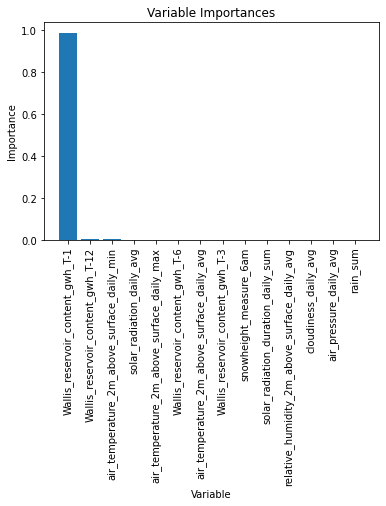

In [ ]:
# Create two lists for variable and value
x_labels = []
x_values = []

for text,value in feature_importances:
  x_labels.append(text)
  x_values.append(value)


# Make a bar chart
plt.bar(x_labels, x_values, orientation = 'vertical')
plt.xticks(rotation=90)
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Below the predicted values are compared to the actual values in a graph. It can be seen that the accuracy of our trained model is high and the predicted values are following the same pattern as the actual values. 

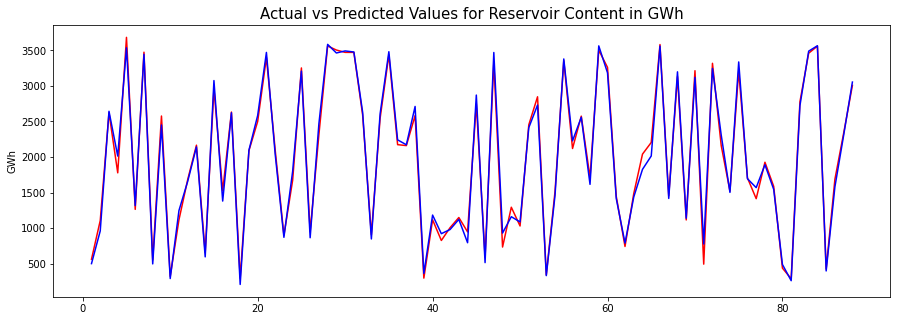

In [ ]:
# Lets try to make a graph indicating the difference in actual and predicted values for the test-data

# Define the values
x_labels = list(range(1,89))
values_pred = predictions
values_actual = test_labels
# Define the plot
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(15,5))
ax1.plot(x_labels, values_pred, color = "red")
ax1.plot(x_labels, values_actual, color = "blue")
ax1.set_title("Actual vs Predicted Values for Reservoir Content in GWh",
              size = 15)
ax1.set_ylabel("GWh")
plt.show();

#### Prediction of new Data with Random Forest Model 2

Originally we extracted the data at the data at the 25.11.2022. 
See the last data point on the index 1194:

In [ ]:
df_water_reservoir.tail(5)

Date  Wallis_reservoir_content_gwh  \
1190 2022-10-24                          3613   
1191 2022-10-31                          3657   
1192 2022-11-07                          3628   
1193 2022-11-14                          3637   
1194 2022-11-21                          3608   

      Graubuenden_reservoir_content_gwh  Tessin_reservoir_content_gwh  \
1190                               1711                           808   
1191                               1790                           858   
1192                               1795                           867   
1193                               1778                           862   
1194                               1761                           855   

      RestCH_reservoir_content_gwh  TotalCH_reservoir_content_gwh  \
1190                          1420                           7552   
1191                          1438                           7743   
1192                          1427                           7717   
1193                          1406                           7683   
1194                          1376                           7600   

      Wallis_reservoir_max_content_gwh  Graubuenden_reservoir_max_content_gwh  \
1190                              4070                                   1970   
1191                              4070                                   1970   
1192                              4070                                   1970   
1193                              4070                                   1970   
1194                              4070                                   1970   

      Tessin_reservoir_max_content_gwh  RestCH_reservoir_max_content_gwh  \
1190                              1245                              1600   
1191                              1245                              1600   
1192                              1245                              1600   
1193                              1245                              1600   
1194                              1245                              1600   

      TotalCH_reservoir_max_content_gwh  Year  Month  
1190                               8885  2022     10  
1191                               8885  2022     10  
1192                               8885  2022     11  
1193                               8885  2022     11  
1194                               8885  2022     11

At the 18.12.2022 we extracted the new data to test our two best models SARIMA and Random Forest Model 2 with new data and by taking the same prediction 

See now the last point at index 1197 (3 weeks ahead)

In [ ]:
# Define data folder:
data_folder = Path("/content/drive/MyDrive/Data Analytics for Energy Systems and IoT/data/")
# Path of product category data
data_new = data_folder/"new_data_water_reservoir.csv"
# Insert the data
df_new_water_reservoir = pd.read_csv(data_new)
df_new_water_reservoir.tail(5)

Datum  Wallis_speicherinhalt_gwh  Graubuenden_speicherinhalt_gwh  \
1193  2022-11-14                       3637                            1778   
1194  2022-11-21                       3608                            1761   
1195  2022-11-28                       3623                            1754   
1196  2022-12-05                       3498                            1673   
1197  2022-12-12                       3348                            1596   

      Tessin_speicherinhalt_gwh  UebrigCH_speicherinhalt_gwh  \
1193                        862                         1406   
1194                        855                         1376   
1195                        849                         1359   
1196                        823                         1306   
1197                        782                         1267   

      TotalCH_speicherinhalt_gwh  Wallis_max_speicherinhalt_gwh  \
1193                        7683                           4070   
1194                        7600                           4070   
1195                        7585                           4070   
1196                        7300                           4070   
1197                        6993                           4070   

      Graubuenden_max_speicherinhalt_gwh  Tessin_max_speicherinhalt_gwh  \
1193                                1970                           1245   
1194                                1970                           1245   
1195                                1970                           1245   
1196                                1970                           1245   
1197                                1970                           1245   

      UebrigCH_max_speicherinhalt_gwh  TotalCH_max_speicherinhalt_gwh  
1193                             1600                            8885  
1194                             1600                            8885  
1195                             1600                            8885  
1196                             1600                            8885  
1197                             1600                            8885

In [ ]:
df_new_water_reservoir['Date']=pd.to_datetime(df_water_reservoir['Date'], format='%Y-%m-%d')

In [ ]:
df_new_water_reservoir = df_new_water_reservoir[["Datum", "Wallis_speicherinhalt_gwh"]]
df_new_water_reservoir.head(5)

Datum  Wallis_speicherinhalt_gwh
0  2000-01-03                       2037
1  2000-01-10                       1945
2  2000-01-17                       1733
3  2000-01-24                       1584
4  2000-01-31                       1414

In [ ]:
df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-1"] = df_new_water_reservoir["Wallis_speicherinhalt_gwh"].shift(+1)
df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-2"] = df_new_water_reservoir["Wallis_speicherinhalt_gwh"].shift(+2)
df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-3"] = df_new_water_reservoir["Wallis_speicherinhalt_gwh"].shift(+3)
df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-4"] = df_new_water_reservoir["Wallis_speicherinhalt_gwh"].shift(+4)
df_new_water_reservoir = df_new_water_reservoir.dropna()
df_new_water_reservoir.tail()

Datum  Wallis_speicherinhalt_gwh  Wallis_speicherinhalt_gwh_T-1  \
1193  2022-11-14                       3637                         3628.0   
1194  2022-11-21                       3608                         3637.0   
1195  2022-11-28                       3623                         3608.0   
1196  2022-12-05                       3498                         3623.0   
1197  2022-12-12                       3348                         3498.0   

      Wallis_speicherinhalt_gwh_T-2  Wallis_speicherinhalt_gwh_T-3  \
1193                         3657.0                         3613.0   
1194                         3628.0                         3657.0   
1195                         3637.0                         3628.0   
1196                         3608.0                         3637.0   
1197                         3623.0                         3608.0   

      Wallis_speicherinhalt_gwh_T-4  
1193                         3591.0  
1194                         3613.0  
1195                         3657.0  
1196                         3628.0  
1197                         3637.0

In [ ]:
df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-1"] = df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-1"].astype("int")
df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-2"] = df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-2"].astype("int")
df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-3"] = df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-3"].astype("int")
df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-4"] = df_new_water_reservoir["Wallis_speicherinhalt_gwh_T-4"].astype("int")
df_new_water_reservoir.dtypes

Datum                            object
Wallis_speicherinhalt_gwh         int64
Wallis_speicherinhalt_gwh_T-1     int64
Wallis_speicherinhalt_gwh_T-2     int64
Wallis_speicherinhalt_gwh_T-3     int64
Wallis_speicherinhalt_gwh_T-4     int64
dtype: object

In [ ]:
df_new_water_reservoir.set_index("Datum", inplace=True)

In [ ]:
end_test = len(df_new_water_reservoir)
print(end_test)
start_test= end_test-16
print(start_test)

train = df_new_water_reservoir.iloc[:start_test] 
test = df_new_water_reservoir.iloc[start_test:end_test]

1194
1178


In [ ]:
train.head(5)

Wallis_speicherinhalt_gwh  Wallis_speicherinhalt_gwh_T-1  \
Datum                                                                  
2000-01-31                       1414                           1584   
2000-02-07                       1285                           1414   
2000-02-14                       1200                           1285   
2000-02-21                       1074                           1200   
2000-02-28                        950                           1074   

            Wallis_speicherinhalt_gwh_T-2  Wallis_speicherinhalt_gwh_T-3  \
Datum                                                                      
2000-01-31                           1733                           1945   
2000-02-07                           1584                           1733   
2000-02-14                           1414                           1584   
2000-02-21                           1285                           1414   
2000-02-28                           1200                           1285   

            Wallis_speicherinhalt_gwh_T-4  
Datum                                      
2000-01-31                           2037  
2000-02-07                           1945  
2000-02-14                           1733  
2000-02-21                           1584  
2000-02-28                           1414

In [ ]:
train_features = np.array(train[["Wallis_speicherinhalt_gwh_T-1",
                                 "Wallis_speicherinhalt_gwh_T-2",
                                 "Wallis_speicherinhalt_gwh_T-3",
                                 "Wallis_speicherinhalt_gwh_T-4"]])
train_labels = np.array(train["Wallis_speicherinhalt_gwh"])

In [ ]:
print(len(train_features))
print(len(train_labels))

1178
1178


In [ ]:
# Train model with 1000 decision trees
rf_new = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf_new.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

Recheck the test-dataset

In [ ]:
test.head(5)

Wallis_speicherinhalt_gwh  Wallis_speicherinhalt_gwh_T-1  \
Datum                                                                  
2022-08-29                       3476                           3397   
2022-09-05                       3537                           3476   
2022-09-12                       3560                           3537   
2022-09-19                       3591                           3560   
2022-09-26                       3577                           3591   

            Wallis_speicherinhalt_gwh_T-2  Wallis_speicherinhalt_gwh_T-3  \
Datum                                                                      
2022-08-29                           3387                           3143   
2022-09-05                           3397                           3387   
2022-09-12                           3476                           3397   
2022-09-19                           3537                           3476   
2022-09-26                           3560                           3537   

            Wallis_speicherinhalt_gwh_T-4  
Datum                                      
2022-08-29                           2931  
2022-09-05                           3143  
2022-09-12                           3387  
2022-09-19                           3397  
2022-09-26                           3476

In [ ]:
# Insert date columns in list fro later use in graph
dates = list(test.index.values)
# Store actual values (labels)
actual_values = np.array(test["Wallis_speicherinhalt_gwh"])

# Refactor dataframe for feature list
test = test[["Wallis_speicherinhalt_gwh_T-1",
             "Wallis_speicherinhalt_gwh_T-2",
             "Wallis_speicherinhalt_gwh_T-3",
             "Wallis_speicherinhalt_gwh_T-4"]]
# Create feature-list
feature_list = list(test.columns)
# Convert test-data to np-array
test = np.array(test[["Wallis_speicherinhalt_gwh_T-1",
                     "Wallis_speicherinhalt_gwh_T-2",
                     "Wallis_speicherinhalt_gwh_T-3",
                     "Wallis_speicherinhalt_gwh_T-4"]])

In [ ]:
# Use the forest's predict method on the test data
predictions = rf_new.predict(test)
# Calculate the absolute errors
errors = abs(predictions - actual_values)
# Calculate Root Mean Squared Error
rmse_rf_new = sqrt(mean_squared_error(predictions, actual_values))
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Mean Squared Error:', round(rmse_rf_new, 2))

Mean Absolute Error: 39.93 degrees.
Mean Squared Error: 52.63


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / actual_values)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 98.87 %.


In [ ]:
# Get numerical feature importances
importances = list(rf_new.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Wallis_speicherinhalt_gwh_T-1 Importance: 0.9869
Variable: Wallis_speicherinhalt_gwh_T-4 Importance: 0.0083
Variable: Wallis_speicherinhalt_gwh_T-3 Importance: 0.004
Variable: Wallis_speicherinhalt_gwh_T-2 Importance: 0.0008


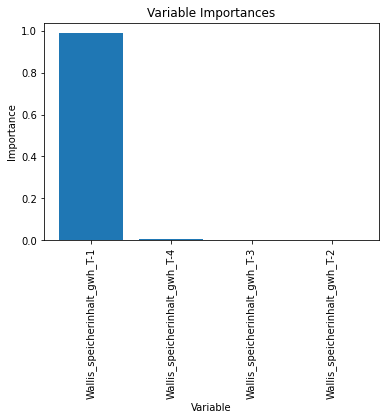

In [ ]:
# Create two lists for variable and value
x_labels = []
x_values = []

for text,value in feature_importances:
  x_labels.append(text)
  x_values.append(value)


# Make a bar chart
plt.bar(x_labels, x_values, orientation = 'vertical')
plt.xticks(rotation=90)
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

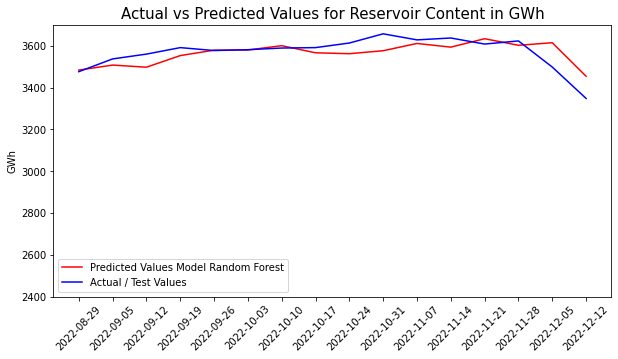

In [ ]:
# Lets try to make a graph indicating the difference in actual and predicted values for the test-data

# Define the values
x_labels = list(range(1,17))
values_pred = predictions
values_actual = actual_values
# Define the plot
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5))
ax1.plot(dates, values_pred, color = "red", label = "Predicted Values Model Random Forest")
ax1.plot(dates, values_actual, color = "blue", label = "Actual / Test Values")
ax1.set_title("Actual vs Predicted Values for Reservoir Content in GWh",
              size = 15)
ax1.set_ylabel("GWh")
ax1.legend()
ax1.set_ylim([2400, 3700])
ax1.set_xticklabels(dates, rotation = 45)
plt.show();

#### Prediction of new Data with SARIMA

In [ ]:
df_new_water_reservoir.tail(5)

Wallis_speicherinhalt_gwh  Wallis_speicherinhalt_gwh_T-1  \
Datum                                                                  
2022-11-14                       3637                           3628   
2022-11-21                       3608                           3637   
2022-11-28                       3623                           3608   
2022-12-05                       3498                           3623   
2022-12-12                       3348                           3498   

            Wallis_speicherinhalt_gwh_T-2  Wallis_speicherinhalt_gwh_T-3  \
Datum                                                                      
2022-11-14                           3657                           3613   
2022-11-21                           3628                           3657   
2022-11-28                           3637                           3628   
2022-12-05                           3608                           3637   
2022-12-12                           3623                           3608   

            Wallis_speicherinhalt_gwh_T-4  
Datum                                      
2022-11-14                           3591  
2022-11-21                           3613  
2022-11-28                           3657  
2022-12-05                           3628  
2022-12-12                           3637

In [ ]:
# Preprocessing
ts_data = df_new_water_reservoir["Wallis_speicherinhalt_gwh"]

ts_wallis_new =  pd.DataFrame(ts_data)
print(ts_wallis_new)
print(type(ts_wallis_new))

            Wallis_speicherinhalt_gwh
Datum                                
2000-01-31                       1414
2000-02-07                       1285
2000-02-14                       1200
2000-02-21                       1074
2000-02-28                        950
...                               ...
2022-11-14                       3637
2022-11-21                       3608
2022-11-28                       3623
2022-12-05                       3498
2022-12-12                       3348

[1194 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Split into test and train

#from sklearn.model_selection import train_test_split
#train, test = train_test_split(ts_wallis, test_size = 0.20, random_state = 42)

end_test = len(ts_wallis_new)
print(end_test)
start_test= end_test-16
print(start_test)

train_new = ts_wallis_new.iloc[:start_test] 
test_new = ts_wallis_new.iloc[start_test:end_test]

1194
1178


In [ ]:
dates = list(test_new.index.values)

In [ ]:
# Store test values
actual_values = np.array(test_new["Wallis_speicherinhalt_gwh"])

In [ ]:
# SARIMA Model
order = (2,1,0)
seasonal_order = (0,1,0,52) 

start = time()
model1 = sm.tsa.arima.ARIMA(train_new, order=order, seasonal_order=seasonal_order)
model1_fit = model1.fit(method='innovations_mle', low_memory=True) #, cov_type='none'
end = time()
print("Model fitting is finished. Fitting Time:", end - start)

Model fitting is finished. Fitting Time: 0.8649215698242188


In [ ]:
predictions_model1_new = model1_fit.forecast(16)

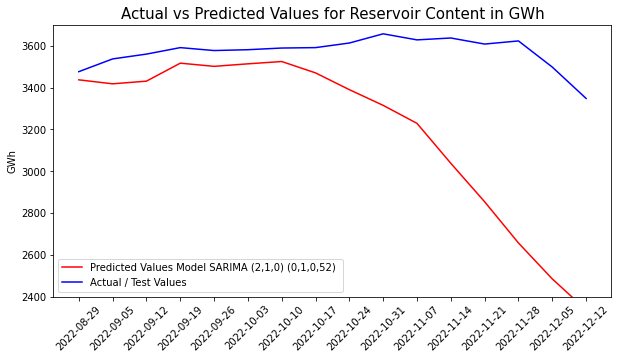

In [ ]:
# Lets try to make a graph indicating the difference in actual and predicted values for the test-data

# Define the values
x_labels = list(range(1,17))
values_pred_new = predictions_model1_new
values_actual_new = test_new

# Define the plot
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5))
ax1.plot(dates, values_pred_new, color = "red", label= "Predicted Values Model SARIMA (2,1,0) (0,1,0,52) ")
ax1.plot(dates, values_actual_new, color = "blue", label ="Actual / Test Values")
ax1.legend()
ax1.set_title("Actual vs Predicted Values for Reservoir Content in GWh",
              size = 15)
ax1.set_ylabel("GWh")
ax1.set_ylim([2400, 3700])
ax1.set_xticklabels(dates, rotation = 45)
plt.show()

In [ ]:
predictions_model1_new = np.array(predictions_model1_new)
print("predictions:", predictions_model1_new)
print("actual/test values:", actual_values)

predictions: [3436.89864071 3417.86136117 3430.64525009 3516.64320364 3501.4262037
 3513.45074984 3524.52534851 3470.09184427 3389.88876921 3314.7936387
 3228.74907481 3037.72819886 2853.71841952 2656.71383839 2484.71169236
 2336.71068705]
actual/test values: [3476 3537 3560 3591 3577 3581 3589 3591 3613 3657 3628 3637 3608 3623
 3498 3348]


In [ ]:
# Change to Data Frame
#predictions_model1_new = pd.DataFrame(predictions_model1_new)

# Calculate the absolute errors
errors_new = abs(predictions_model1_new- actual_values)

# Calculate Root Mean Squared Error
rmse_new = sqrt(mean_squared_error(predictions_model1_new, actual_values))

# Print out the mean absolute error (mae)
print('Mean Absolute Error', round(np.mean(errors_new), 2), 'degrees.')
print('Mean Squared Error:', round(rmse_new, 2))

Mean Absolute Error 374.97 degrees.
Mean Squared Error: 518.69


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape_new = 100 * (errors_new / actual_values)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape_new)
print('Accuracy of SARIMA Model:', round(accuracy, 2), '%.')

Accuracy of SARIMA Model: 89.43 %.


Random Forest is performing better with a Accuracy of 98.87 %.

#### Conclusion

- Based on the same test data Random Forest has a better accuracy with 98.87 % in comparison to SARIMA with a accuracy of 89.43 %.  

- Based on the model we can not detect a relationship of melting snow on the reservoir level
- Other weather influences can not be detected by the model
- Many more variables are influencing the water reservoir content as in our models
- EDA is a crucial part of Data Science - Sometimes you have to step back to understand the context and re evaluate the model decisions
